In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from astropy.cosmology import Planck18 as cosmo
from astropy.cosmology import z_at_value
from scipy import integrate
from scipy.integrate import quad
from scipy.special import gamma
from scipy.interpolate import interp1d
from scipy.integrate import simpson

import astropy.units as u
import bz2
import os

%config InlineBackend.figure_format ='retina'
plt.rcParams["text.usetex"] = True

# Optical Depths

Here the three optical depths considered for the three different lens models are constructed: the z-independent, the z-dependent 1, and the z-dependent 2. More information about the defined constants can be found in the paper.

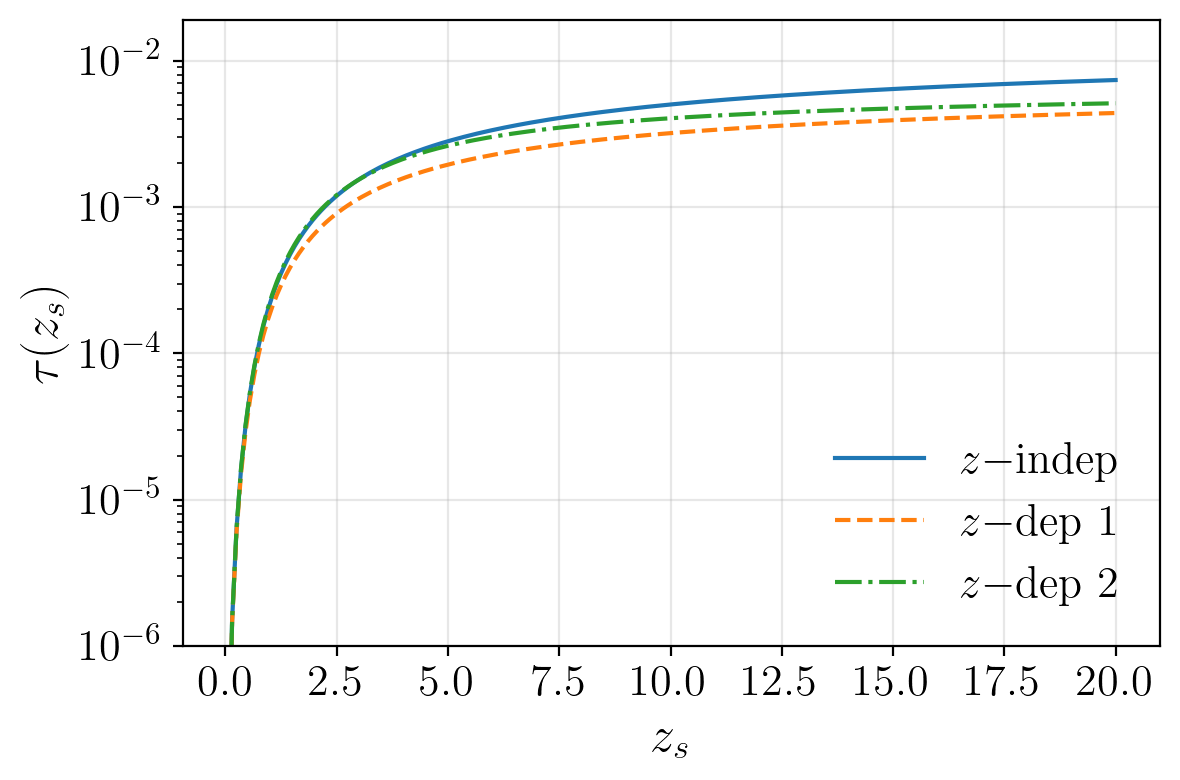

In [2]:
h = cosmo.h
H0 = cosmo.H0.value 
phi_star0 = 2.099e-2 * (h/0.7)**3   
sigma_star0 = 113.78
alpha, beta = 0.94, 1.85
nu_n, nu_v = -1.18,0.18               
c_km_s = 3.0e5

z_grid = np.linspace(0.05, 20.0, 200)

# --z independent model--

def tau_indep(zS):    
    F_star = 0.000489386
    Dc = cosmo.comoving_distance(zS).to(u.Mpc).value  
    return F_star  * (H0 * Dc / c_km_s) ** 3

tau_indep_vals = np.array([tau_indep(z) for z in z_grid])

# --z dependent 1--

prefactor = (16 * np.pi**3 * phi_star0 *c_km_s* gamma((4+alpha)/beta) / gamma(alpha/beta) * (sigma_star0 / c_km_s)**4)

def integrand(zL, zS):
    DL = cosmo.angular_diameter_distance(zL).to(u.Mpc).value
    DS = cosmo.angular_diameter_distance(zS).to(u.Mpc).value
    DLS = cosmo.angular_diameter_distance_z1z2(zL, zS).to(u.Mpc).value
    
    Hz = cosmo.H(zL).to(u.km/u.s/u.Mpc).value
    
    evo = (1.0 + zL)**(2.0 + nu_n + 4.0*nu_v)
    
    geom = (DL * DLS / DS)**2
    return evo / Hz * geom

def tau_dep1(zS):
    if zS <= 0:
        return 0.0
    val, _ = quad(integrand, 0.0, zS, args=(zS,), epsabs=0, epsrel=1e-5, limit=200)
    return prefactor * val

tau_dep1_vals = np.array([tau_dep1(z) for z in z_grid])

# -- z dependent 2 --

def phi_indep(sigma):    
    phi_indep = phi_star0 * (sigma/sigma_star0)**alpha * np.exp(-(sigma/sigma_star0)**beta) * beta/(gamma(alpha/beta) * sigma)
    return phi_indep

def phi_dep2(sigma, z):
    a0, a1, a2    = 7.391498,  5.729400,  -1.120552
    al0, al1, al2 = -6.863393, -5.273271,  1.104114
    be0, be1, be2 = 2.852083,  1.255696,  -0.286638
    ga0, ga1, ga2 = 0.067032,  -0.048683,  0.007648

    def phi_hyd(sigma, z):
        A_hyd     = a0  + a1*z  + a2*z**2
        alpha_hyd = al0 + al1*z + al2*z**2
        beta_hyd  = be0 + be1*z + be2*z**2
        gamma_hyd = ga0 + ga1*z + ga2*z**2
        sigma_star_hyd = 10**gamma_hyd

        x = np.log10(sigma / sigma_star_hyd)
        n = 10**(A_hyd + alpha_hyd*x + beta_hyd*x**2 - np.exp(x))

        phi1 = n/sigma * (alpha_hyd + 2*beta_hyd*x - np.exp(x))

        return phi1

    phi_z = phi_hyd(sigma, z)
    phi_0 = phi_hyd(sigma, 0.0)
    ratio = phi_z / phi_0

    return ratio * phi_indep(sigma)

def sigma_integral(zL):
    integrand = lambda s: s**4 * phi_dep2(s, zL)
    val, _ = quad(integrand, 63, 1e3, epsrel=1e-5)
    return val

def z_integral(zL, zS):
    DL = cosmo.angular_diameter_distance(zL).to(u.Mpc).value
    DS = cosmo.angular_diameter_distance(zS).to(u.Mpc).value
    DLS = cosmo.angular_diameter_distance_z1z2(zL, zS).to(u.Mpc).value
    Hz = cosmo.H(zL).to(u.km/u.s/u.Mpc).value
    
    geom = (DL*DLS/DS)**2
    return (1+zL)**2 / Hz * geom * sigma_integral(zL)

def tau_dep2(zS):
    pref = 16*np.pi**3 / c_km_s**3
    val, _ = quad(z_integral, 0, zS, args=(zS,), epsrel=1e-4, limit=200)
    return pref * val

tau_dep2_vals = np.array([tau_dep2(z) for z in z_grid])


plt.figure(figsize=(6,4))

plt.plot(z_grid, tau_indep_vals, linestyle='-', label=r'$z \mathrm{-indep}$', lw = 1.5)
plt.plot(z_grid, tau_dep1_vals, label=r'$z\mathrm{-dep\ 1}$', ls = '--', lw = 1.5)
plt.plot(z_grid, tau_dep2_vals, label=r'$z\mathrm{-dep\ 2}$', ls = '-.', lw = 1.5)

plt.yscale('log')
plt.xlabel(r"$z_s$", fontsize = 18)
plt.ylabel(r"$\tau(z_s)$",fontsize = 18)
plt.ylim(1e-6, 1.9e-2)
plt.grid(True, alpha= 0.3)
plt.xticks(np.arange(0, 21, 2.5))
plt.tick_params(labelsize = 16)
plt.legend(fontsize = 16, frameon=False)
plt.tight_layout()

plt.savefig("github/Images/tau_3models.pdf", dpi=300)
plt.show()

# Strongly Lensed Events 

First the redshifts of the lenses are sampled considering the different optical depths. Angular distances to the lenses and between the lenses and the sources are also calculated.

The first two cells are used to see how the distribution of the lenses evolves with respect to the redshift of the source.

Three new catalogs (one for each lens model) will be created for each simulation, depending on the optical depth of each model.

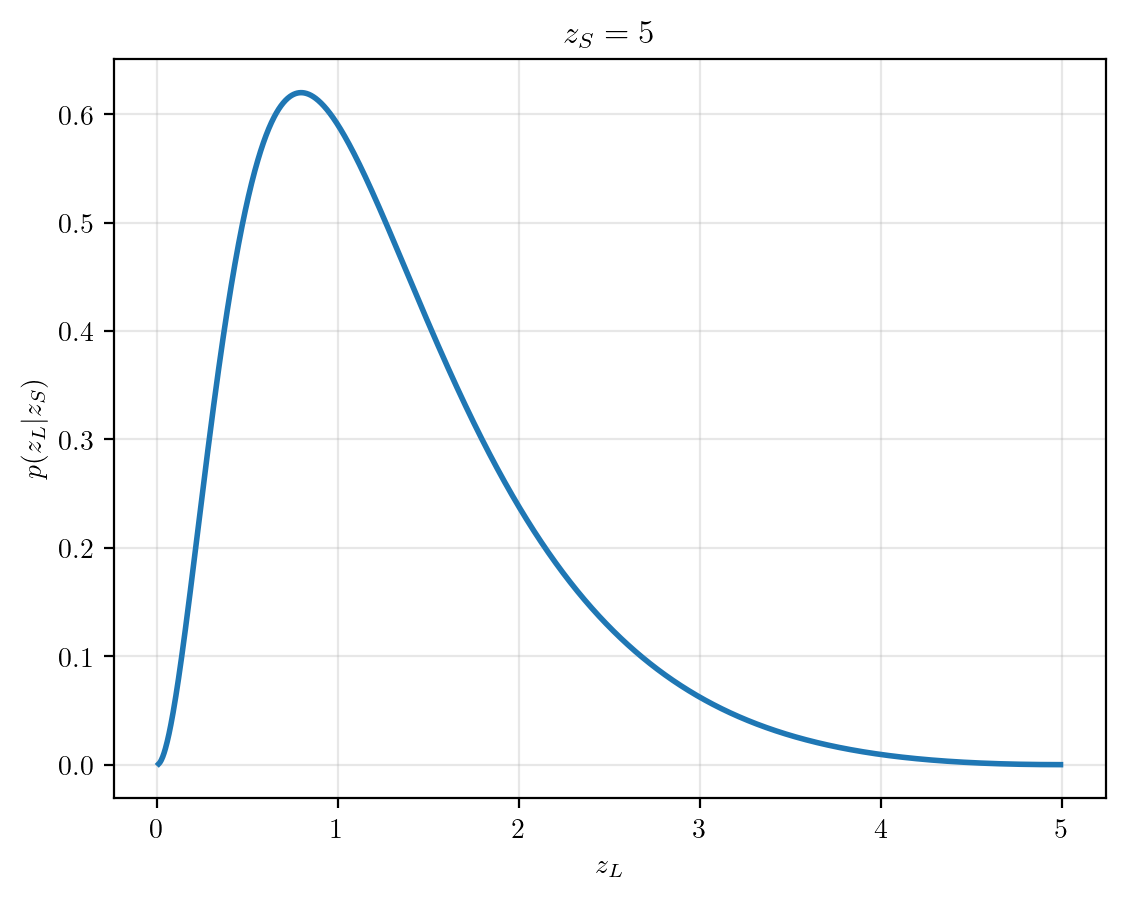

Peak in z_L = 0.797


In [4]:
zs = 5 # for the z dependent 1 model 

nun, nuv = -1.18, 0.18

zl = np.linspace(0.01, zs-0.01, 2000)  

Dc_s = cosmo.comoving_distance(zs).value      
Dc_l = cosmo.comoving_distance(zl).value      
H_l  = cosmo.H(zl).value  

r = Dc_l / Dc_s

p = ((1 + zl)**(nun + 4*nuv)) * (r**2 * (1 - r)**2) / H_l

dz = np.gradient(zl)
p_norm = p / np.sum(p * dz)

plt.plot(zl, p_norm, lw=2)
plt.xlabel(r"$z_L$")
plt.ylabel(r"$p(z_L|z_S)$")
plt.title(f" $z_S={zs}$")
plt.grid(True, alpha=0.3)
plt.show()

peak_idx = np.argmax(p_norm)   
zl_peak = zl[peak_idx]         
p_peak  = p_norm[peak_idx]    

print(f"Peak in z_L = {zl_peak:.3f}")

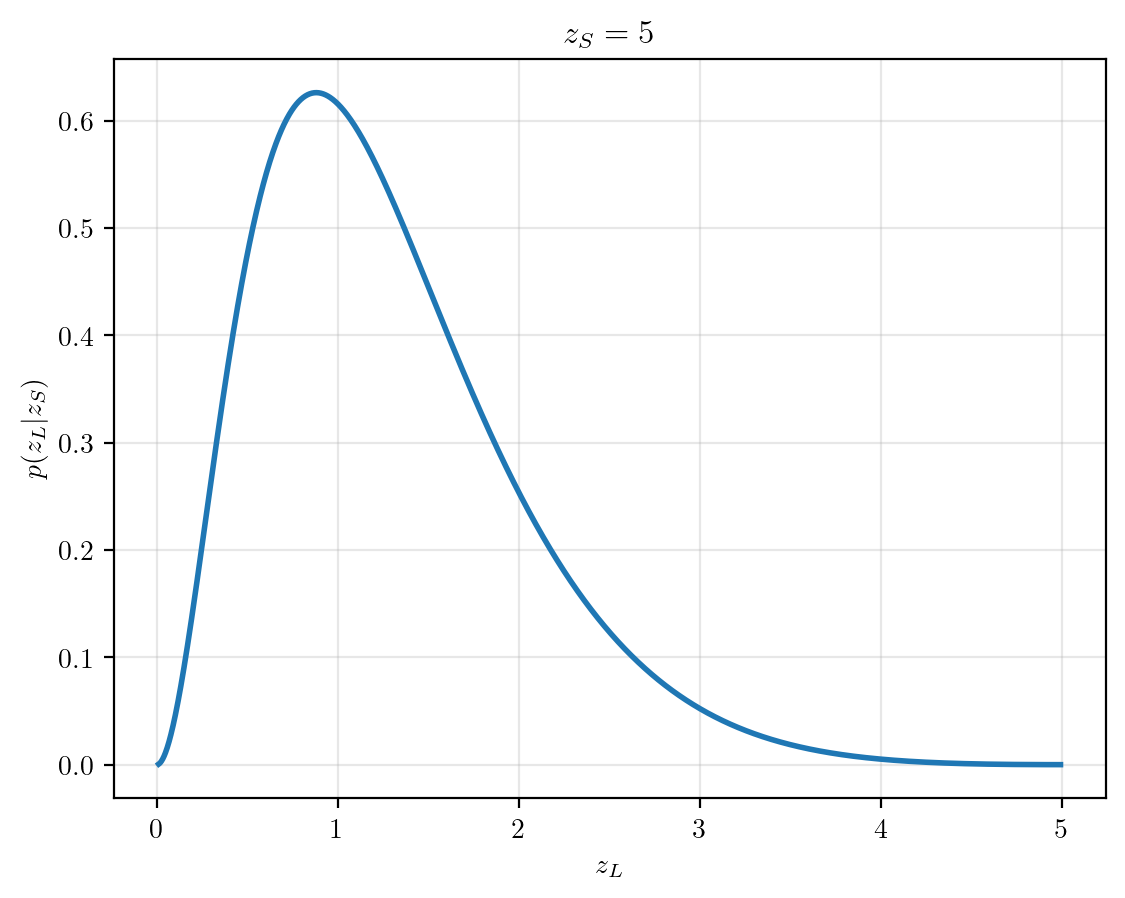

 Peak inz_L = 0.879


In [3]:
# for the z dependent 2 model 

zs = 5   # change z source to see how the distribution evolves

zl = np.linspace(0.01, zs-0.01, 2000)

Dc_s = cosmo.comoving_distance(zs).value      
Dc_l = cosmo.comoving_distance(zl).value      
H_l  = cosmo.H(zl).value  

r = Dc_l / Dc_s

def phi_indep(sigma):
    phi_star0 = 2.099e-2 * (cosmo.h/0.7)**3
    sigma_star = 113.78
    alpha, beta = 0.94, 1.85
    return phi_star0*(sigma/sigma_star)**alpha*np.exp(-(sigma/sigma_star)**beta)*beta/(gamma(alpha/beta)*sigma)

def phi_dep2(sigma, z):
    a0, a1, a2   = 7.391498, 5.729400, -1.120552
    al0, al1, al2 = -6.863393, -5.273271, 1.104114
    be0, be1, be2 = 2.852083, 1.255696, -0.286638
    ga0, ga1, ga2 = 0.067032, -0.048683, 0.007648

    def phi_hyd(sigma, z):
        A_hyd     = a0  + a1*z  + a2*z**2
        alpha_hyd = al0 + al1*z + al2*z**2
        beta_hyd  = be0 + be1*z + be2*z**2
        gamma_hyd = ga0 + ga1*z + ga2*z**2
        sigma_star_hyd = 10**gamma_hyd

        x = np.log10(sigma / sigma_star_hyd)
        n = 10**(A_hyd + alpha_hyd*x + beta_hyd*x**2 - np.exp(x))

        phi1 = n/sigma * (alpha_hyd + 2*beta_hyd*x - np.exp(x))
        return phi1

    phi_z = phi_hyd(sigma, z)
    phi_0 = phi_hyd(sigma, 0.0)
    ratio = phi_z / phi_0

    return ratio * phi_indep(sigma)

def sigma_integral(zL):
    integrand = lambda s: s**4 * phi_dep2(s, zL)
    val, _ = quad(integrand, 1, 1e3, epsrel=1e-5)
    return val

def build_sigma_interp(zmin=0.01, zmax=20, ngrid=100):
    z_vals = np.linspace(zmin, zmax, ngrid)
    sig_vals = np.array([sigma_integral(z) for z in z_vals])
    return interp1d(z_vals, sig_vals, kind="cubic", bounds_error=False, fill_value="extrapolate")

sigma_interp = build_sigma_interp()

sig_vals = sigma_interp(zl)

p = (r**2 * (1 - r)**2) / H_l * sig_vals

dz = np.gradient(zl)
p_norm = p / np.sum(p * dz)

plt.plot(zl, p_norm, lw=2)
plt.xlabel(r"$z_L$")
plt.ylabel(r"$p(z_L|z_S)$")
plt.title(f" $z_S={zs}$")
plt.grid(True, alpha=0.3)
plt.show()

peak_idx = np.argmax(p_norm)   
zl_peak = zl[peak_idx]         

print(f" Peak inz_L = {zl_peak:.3f}")

In [5]:
# here is where the sampling of z_L is done (this cell can also be omitted if you use github catalogs)

from tqdm import tqdm
tqdm.pandas() 

file_paths = [   # edit according to the file paths if necessary
    "github/HSnodSNhighaccr/HSnodSNhighaccr_SNRLb_final.csv",
    "github/HSnodnoSN/HSnodnoSN_SNRLb_final.csv",            
    "github/HSnodSN/HSnodSN_SNRLb_final.csv",                
    "github/PopIIId/PopIIId_SNRLb_final.csv",                
    "github/Q3nod/Q3nod_SNRLb_final.csv",                    
    "github/Q3d/Q3d_SNRLb_final.csv",                        
]  

for file in file_paths:
    df = pd.read_csv(file)  
    
    zl_grid = np.linspace(0.01, df['z_merger'].max()-0.01,1000)
    
    df["Dc_s"] = cosmo.comoving_distance(df["z_merger"]).value  
    df["Da_s"] = cosmo.angular_diameter_distance(df["z_merger"]).value
    
    # -- redshift independant (lens 1) --
    
    df["Dc_l1"] = df["Dc_s"] * np.random.beta(3, 3, size=len(df))     
    df["z_l1"] = df["Dc_l1"].progress_apply(lambda d: z_at_value(cosmo.comoving_distance, d * u.Mpc).value)
    df["Da_l1"] = cosmo.angular_diameter_distance(df["z_l1"]).value
    df["Da_l1s"] = cosmo.angular_diameter_distance_z1z2(df["z_l1"], df["z_merger"]).value
    
    # -- redshift dependant 1 (lens 2) --
    
    nun, nuv = -1.18, 0.18
    
    def pdf_zl2_given_zs(zs, zl_grid):                   # first, the PDF (which depends on z_s) is defined
        Dc_s = cosmo.comoving_distance(zs).value
        Dc_l = cosmo.comoving_distance(zl_grid).value
        H_l  = cosmo.H(zl_grid).value
        r = Dc_l / Dc_s
        pdf =((1 + zl_grid)**(nun + 4*nuv)) * (r**2 * (1-r)**2) / H_l
        pdf /= np.trapezoid(pdf, zl_grid)
        return pdf
    
    def sample_zl2(zs, ngrid=200):                        # and then z_L is sampled
        zl_grid = np.linspace(0.01, zs-0.01, ngrid)
        pdf = pdf_zl2_given_zs(zs, zl_grid)
        cdf = np.cumsum((pdf[:-1]+pdf[1:]) * np.diff(zl_grid)/2)
        cdf = np.concatenate([[0], cdf/cdf[-1]])
        u = np.random.rand()
        return np.interp(u, cdf, zl_grid)
    
    df['z_l2'] = df['z_merger'].apply(sample_zl2)
    df["Dc_l2"] = cosmo.comoving_distance(df["z_l2"]).value  
    df["Da_l2"] = cosmo.angular_diameter_distance(df["z_l2"]).value
    df["Da_l2s"] = cosmo.angular_diameter_distance_z1z2(df["z_l2"], df["z_merger"]).value
    
    # -- redshift dependant 2 (lens 3) --
    
    def phi_indep(sigma):               # same procedure, but now it's a little more complicated because you have to integrate in sigma to construct the pdf
        phi_star0 = 2.099e-2 * (cosmo.h/0.7)**3
        sigma_star = 113.78
        alpha, beta = 0.94, 1.85
        return phi_star0*(sigma/sigma_star)**alpha*np.exp(-(sigma/sigma_star)**beta)*beta/(gamma(alpha/beta)*sigma)
    
    def phi_dep2(sigma, z):
        a0, a1, a2   = 7.391498, 5.729400, -1.120552
        al0, al1, al2 = -6.863393, -5.273271, 1.104114
        be0, be1, be2 = 2.852083, 1.255696, -0.286638
        ga0, ga1, ga2 = 0.067032, -0.048683, 0.007648
    
        def phi_hyd(sigma, z):
            A_hyd     = a0  + a1*z  + a2*z**2
            alpha_hyd = al0 + al1*z + al2*z**2
            beta_hyd  = be0 + be1*z + be2*z**2
            gamma_hyd = ga0 + ga1*z + ga2*z**2
            sigma_star_hyd = 10**gamma_hyd
    
            x = np.log10(sigma / sigma_star_hyd)
            n = 10**(A_hyd + alpha_hyd*x + beta_hyd*x**2 - np.exp(x))
    
            phi1 = n/sigma * (alpha_hyd + 2*beta_hyd*x - np.exp(x))
            return phi1
    
        phi_z = phi_hyd(sigma, z)
        phi_0 = phi_hyd(sigma, 0.0)
        ratio = phi_z / phi_0
    
        return ratio * phi_indep(sigma)
    
    def sigma_integral(zL):
        integrand = lambda s: s**4 * phi_dep2(s, zL)
        val, _ = quad(integrand, 1, 1e3, epsrel=1e-5)
        return val
    
    def build_sigma_interp(zmin=0.01, zmax=20, ngrid=100):
        z_vals = np.linspace(zmin, zmax, ngrid)
        sig_vals = np.array([sigma_integral(z) for z in z_vals])
        return interp1d(z_vals, sig_vals, kind="cubic", bounds_error=False, fill_value="extrapolate")
    
    sigma_interp = build_sigma_interp()
    
    def pdf_zl3_given_zs(zs, zl_grid):
        Dc_s = cosmo.comoving_distance(zs).value
        Dc_l = cosmo.comoving_distance(zl_grid).value
        H_l  = cosmo.H(zl_grid).value
        r = Dc_l / Dc_s
        sig_vals = sigma_interp(zl_grid)
        pdf =(r**2 * (1-r)**2) / H_l * sig_vals        # here the pdf
        norm = np.trapezoid(pdf, zl_grid)
        if norm == 0:
            return np.zeros_like(pdf)
        return pdf / norm
    
    def sample_zl3(zs, ngrid=200):
        zl_grid = np.linspace(0.01, zs-0.01, ngrid)
        pdf = pdf_zl3_given_zs(zs, zl_grid)
        cdf = np.cumsum((pdf[:-1]+pdf[1:]) * np.diff(zl_grid)/2)
        cdf = np.concatenate([[0], cdf/cdf[-1]])
        u = np.random.rand()
        return np.interp(u, cdf, zl_grid)
    
    df['z_l3'] = df['z_merger'].apply(sample_zl3)
    df["Dc_l3"] = cosmo.comoving_distance(df["z_l3"]).value  
    df["Da_l3"] = cosmo.angular_diameter_distance(df["z_l3"]).value
    df["Da_l3s"] = cosmo.angular_diameter_distance_z1z2(df["z_l3"], df["z_merger"]).value
    
    df.to_csv(file, index=False)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:09<00:00, 1039.09it/s]


In [9]:
# calculation of optical depths for each event and number of intrinsical strongly lensed events, this cell may take a while to run (this cell can also be omitted if you use github catalogs)

tqdm.pandas()  

file_paths = [ # edit according to the file paths if necessary
        ("github/HSnodSNhighaccr/HSnodSNhighaccr_SNRLb_final.csv", 1.0630494636915455),
        ("github/HSnodnoSN/HSnodnoSN_SNRLb_final.csv",             0.25404047565928967),
        ("github/HSnodSN/HSnodSN_SNRLb_final.csv",                 0.27181526086667807),
        ("github/PopIIId/PopIIId_SNRLb_final.csv",                 7.092047686928647),
        ("github/Q3nod/Q3nod_SNRLb_final.csv",                     15.215581973187101),
        ("github/Q3d/Q3d_SNRLb_final.csv",                         136.01186023421243)
]

for file_path, norm in file_paths:
    print(f"\nProcessing file: {file_path}")
    df = pd.read_csv(file_path)

    df["tau_indep"] =df["z_merger"].progress_apply(lambda z: tau_indep(z))
    df["tau_dep1"] = df["z_merger"].progress_apply(lambda z: tau_dep1(z))
    df["tau_dep2"] = df["z_merger"].progress_apply(lambda z: tau_dep2(z))

    print(f"Total intrinsic unlensed events: {len(df)/norm:.3f}")
    print(f"Total intrinsic events lensed for tau z-indep: {df['tau_indep'].sum()/norm:.3f}")
    print(f"Total intrinsic events lensed for tau z-dep 1: {df['tau_dep1'].sum()/norm:.3f}")
    print(f"Total intrinsic events lensed for tau z-dep 2: {df['tau_dep2'].sum()/norm:.3f}")

    df.to_csv(file_path, index=False)


Processing file: github/HSnodSNhighaccr/HSnodSNhighaccr_SNRLb_final.csv


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [13:02<00:00, 12.78it/s]


Total intrinsic unlensed events: 9406.900
Total intrinsic events lensed for tau z-indep: 51.155
Total intrinsic events lensed for tau z-dep 1: 31.878
Total intrinsic events lensed for tau z-dep 2: 40.742

Processing file: github/HSnodnoSN/HSnodnoSN_SNRLb_final.csv


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [14:25<00:00, 11.55it/s]


Total intrinsic unlensed events: 39363.806
Total intrinsic events lensed for tau z-indep: 231.289
Total intrinsic events lensed for tau z-dep 1: 142.757
Total intrinsic events lensed for tau z-dep 2: 180.804

Processing file: github/HSnodSN/HSnodSN_SNRLb_final.csv


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [14:12<00:00, 11.73it/s]


Total intrinsic unlensed events: 36789.693
Total intrinsic events lensed for tau z-indep: 215.574
Total intrinsic events lensed for tau z-dep 1: 133.140
Total intrinsic events lensed for tau z-dep 2: 168.738

Processing file: github/PopIIId/PopIIId_SNRLb_final.csv


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [11:02<00:00, 15.09it/s]


Total intrinsic unlensed events: 1410.030
Total intrinsic events lensed for tau z-indep: 6.897
Total intrinsic events lensed for tau z-dep 1: 4.376
Total intrinsic events lensed for tau z-dep 2: 5.697

Processing file: github/Q3nod/Q3nod_SNRLb_final.csv


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [09:54<00:00, 16.81it/s]


Total intrinsic unlensed events: 657.221
Total intrinsic events lensed for tau z-indep: 2.904
Total intrinsic events lensed for tau z-dep 1: 1.857
Total intrinsic events lensed for tau z-dep 2: 2.426

Processing file: github/Q3d/Q3d_SNRLb_final.csv


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [05:32<00:00, 30.06it/s]


Total intrinsic unlensed events: 73.523
Total intrinsic events lensed for tau z-indep: 0.199
Total intrinsic events lensed for tau z-dep 1: 0.136
Total intrinsic events lensed for tau z-dep 2: 0.186


In [11]:
# here three new catalogs (one for each lens model) of 5,000 events each are sampled, taking optical depth as probability

tqdm.pandas()  

file_paths = [ # edit according to the file paths if necessary
    ("github/PopIIId/PopIIId_SNRLb_final.csv",                 "github/PopIIId/PopIIId_z_indep.csv",                 "github/PopIIId/PopIIId_z_dep1.csv",                 "github/PopIIId/PopIIId_z_dep2.csv"),
    ("github/Q3d/Q3d_SNRLb_final.csv",                         "github/Q3d/Q3d_z_indep.csv",                         "github/Q3d/Q3d_z_dep1.csv",                         "github/Q3d/Q3d_z_dep2.csv"), 
    ("github/Q3nod/Q3nod_SNRLb_final.csv",                     "github/Q3nod/Q3nod_z_indep.csv",                     "github/Q3nod/Q3nod_z_dep1.csv",                     "github/Q3nod/Q3nod_z_dep2.csv"),
    ("github/HSnodnoSN/HSnodnoSN_SNRLb_final.csv",             "github/HSnodnoSN/HSnodnoSN_z_indep.csv",             "github/HSnodnoSN/HSnodnoSN_z_dep1.csv",             "github/HSnodnoSN/HSnodnoSN_z_dep2.csv"),
    ("github/HSnodSN/HSnodSN_SNRLb_final.csv",                 "github/HSnodSN/HSnodSN_z_indep.csv",                 "github/HSnodSN/HSnodSN_z_dep1.csv",                 "github/HSnodSN/HSnodSN_z_dep2.csv"),
    ("github/HSnodSNhighaccr/HSnodSNhighaccr_SNRLb_final.csv", "github/HSnodSNhighaccr/HSnodSNhighaccr_z_indep.csv", "github/HSnodSNhighaccr/HSnodSNhighaccr_z_dep1.csv", "github/HSnodSNhighaccr/HSnodSNhighaccr_z_dep2.csv")
]

for file, indep, dep_1, dep_2 in file_paths:
    df = pd.read_csv(file)
    
    probabilities = df["tau_indep"] / df["tau_indep"].sum()
    sampled_events = df.sample(n=5000, weights=probabilities, replace=False)
    sampled_events.to_csv(indep, index=False)
    
    probabilities = df["tau_dep1"] / df["tau_dep1"].sum()
    sampled_events = df.sample(n=5000, weights=probabilities, replace=False)
    sampled_events.to_csv(dep_1, index=False)

    probabilities = df["tau_dep2"] / df["tau_dep2"].sum()
    sampled_events = df.sample(n=5000, weights=probabilities, replace=False)
    sampled_events.to_csv(dep_2, index=False)

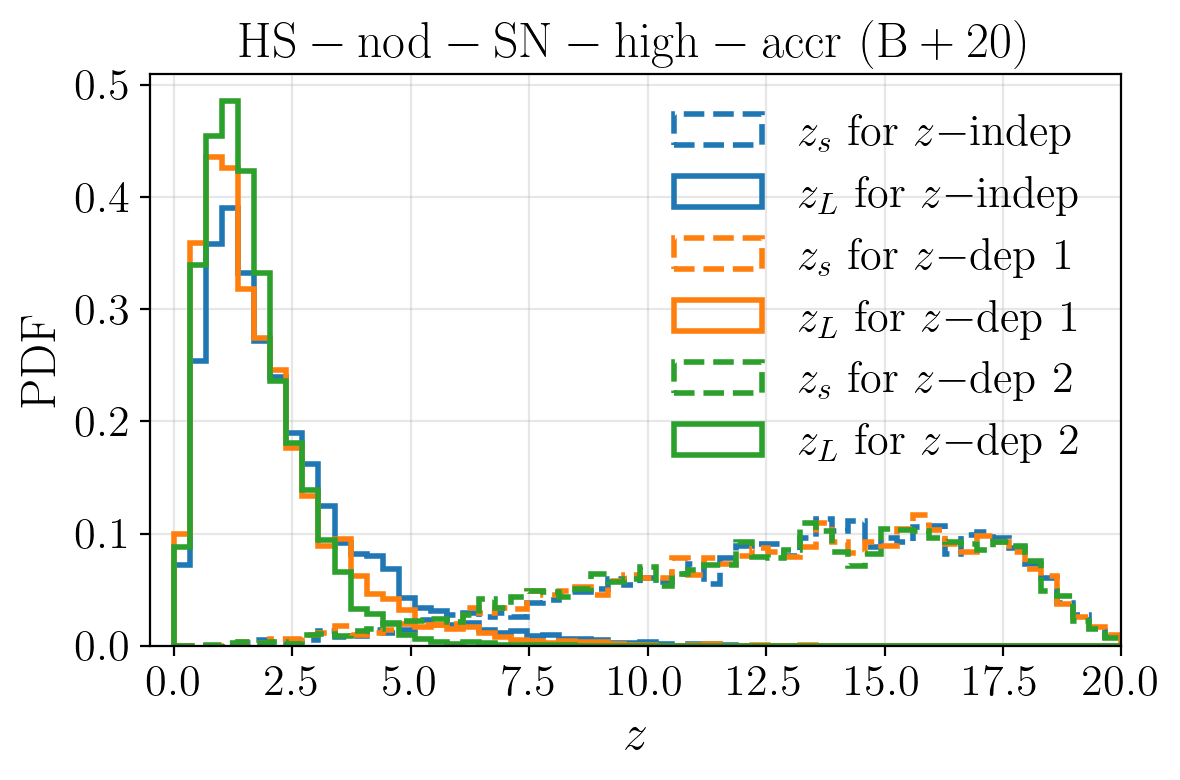

Percentage of events with z_l1 < 1: 22.28
Percentage of events with z_l1 < 3: 76.46
Percentage of events with z_l1 < 6: 96.26
Percentage of events with z_l2 < 1: 29.580000000000002
Percentage of events with z_l2 < 3: 83.08
Percentage of events with z_l2 < 6: 97.74000000000001
Percentage of events with z_l3 < 1: 29.060000000000002
Percentage of events with z_l3 < 3: 90.32
Percentage of events with z_l3 < 6: 99.7


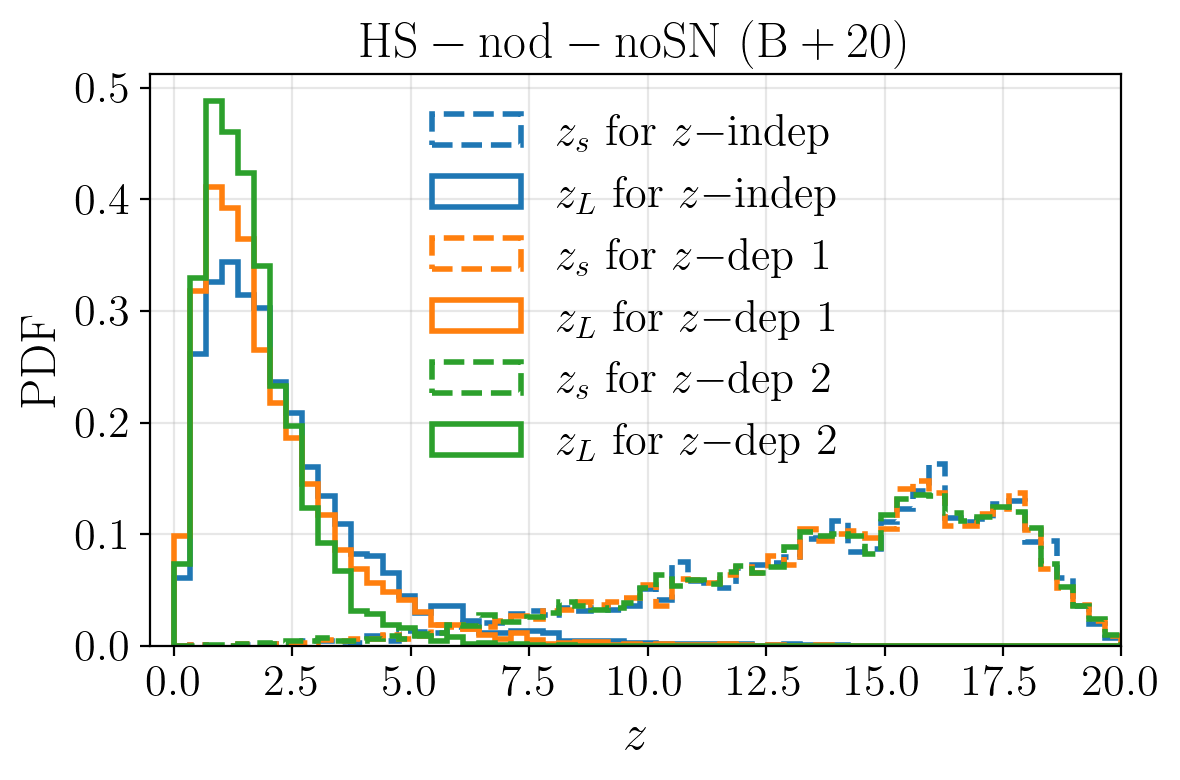

Percentage of events with z_l1 < 1: 21.34
Percentage of events with z_l1 < 3: 74.16
Percentage of events with z_l1 < 6: 95.66
Percentage of events with z_l2 < 1: 27.42
Percentage of events with z_l2 < 3: 80.46
Percentage of events with z_l2 < 6: 97.48
Percentage of events with z_l3 < 1: 29.38
Percentage of events with z_l3 < 3: 89.94
Percentage of events with z_l3 < 6: 99.72


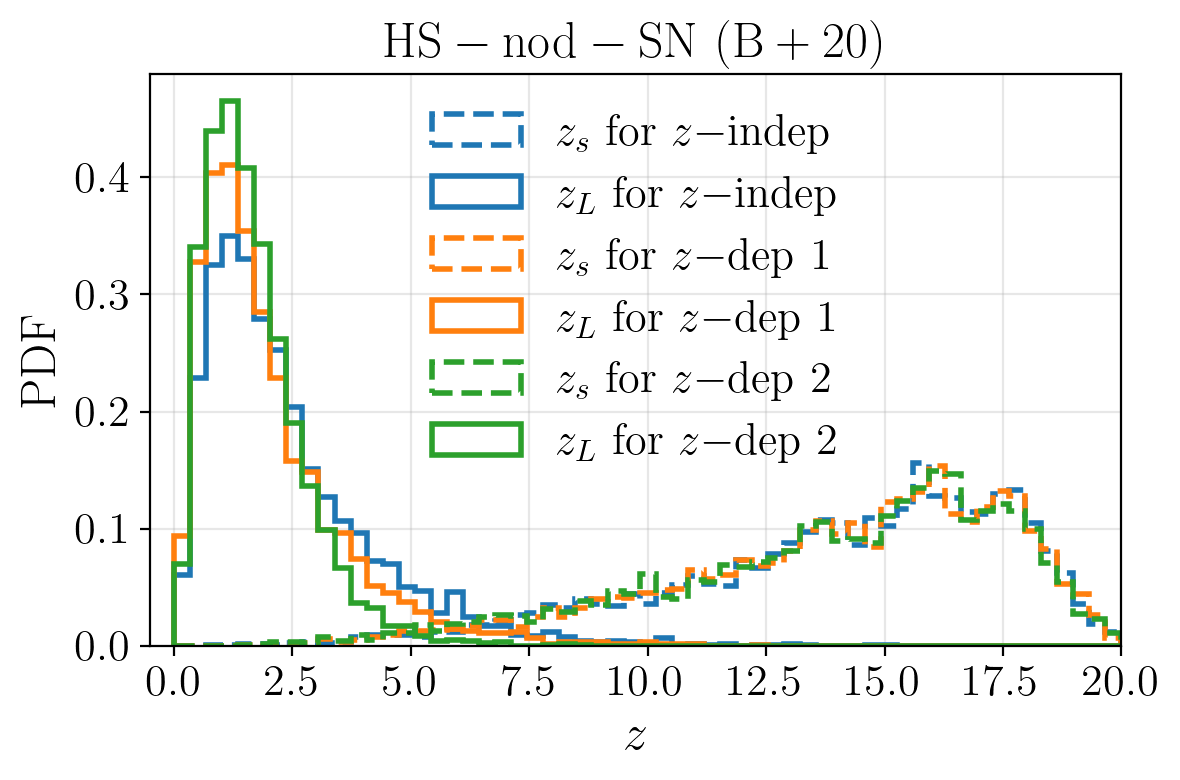

Percentage of events with z_l1 < 1: 20.32
Percentage of events with z_l1 < 3: 73.28
Percentage of events with z_l1 < 6: 95.38
Percentage of events with z_l2 < 1: 27.279999999999998
Percentage of events with z_l2 < 3: 80.84
Percentage of events with z_l2 < 6: 97.34
Percentage of events with z_l3 < 1: 27.900000000000002
Percentage of events with z_l3 < 3: 89.58
Percentage of events with z_l3 < 6: 99.56


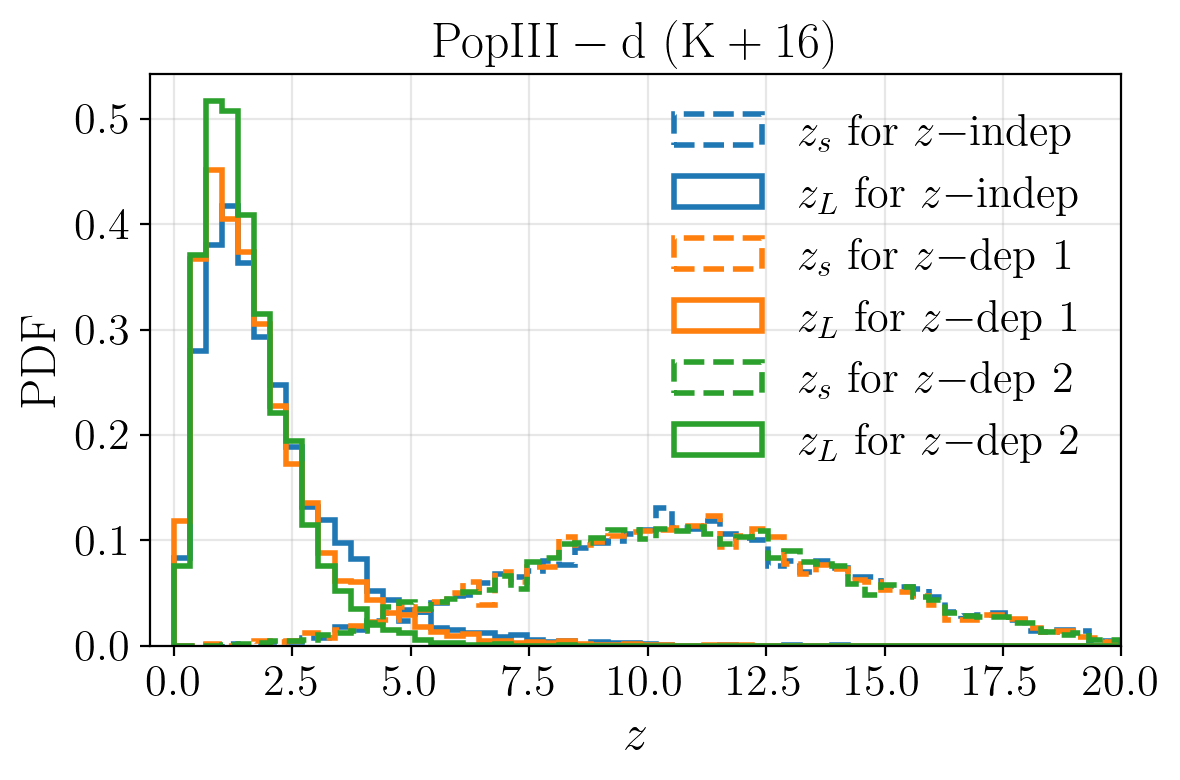

Percentage of events with z_l1 < 1: 24.38
Percentage of events with z_l1 < 3: 80.28
Percentage of events with z_l1 < 6: 97.44
Percentage of events with z_l2 < 1: 30.9
Percentage of events with z_l2 < 3: 85.84
Percentage of events with z_l2 < 6: 98.58
Percentage of events with z_l3 < 1: 31.680000000000003
Percentage of events with z_l3 < 3: 91.8
Percentage of events with z_l3 < 6: 99.82


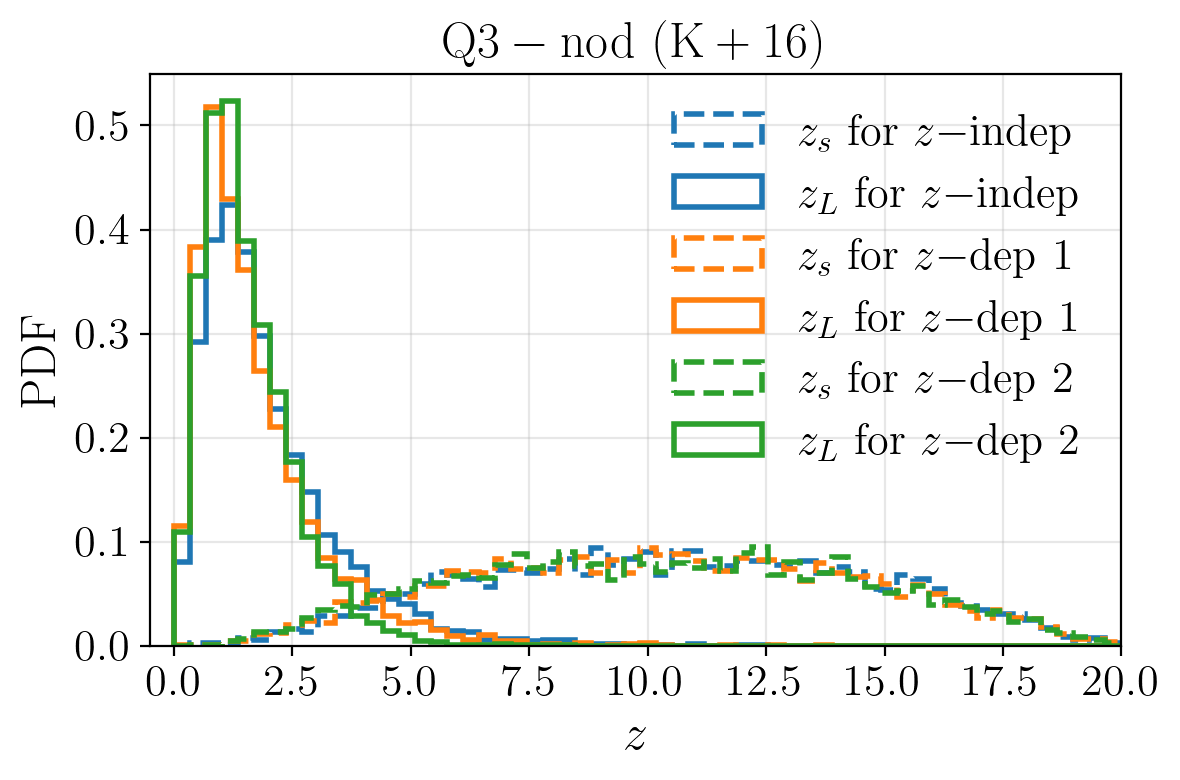

Percentage of events with z_l1 < 1: 25.240000000000002
Percentage of events with z_l1 < 3: 81.2
Percentage of events with z_l1 < 6: 97.88
Percentage of events with z_l2 < 1: 33.76
Percentage of events with z_l2 < 3: 86.26
Percentage of events with z_l2 < 6: 98.61999999999999
Percentage of events with z_l3 < 1: 32.4
Percentage of events with z_l3 < 3: 91.84
Percentage of events with z_l3 < 6: 99.78


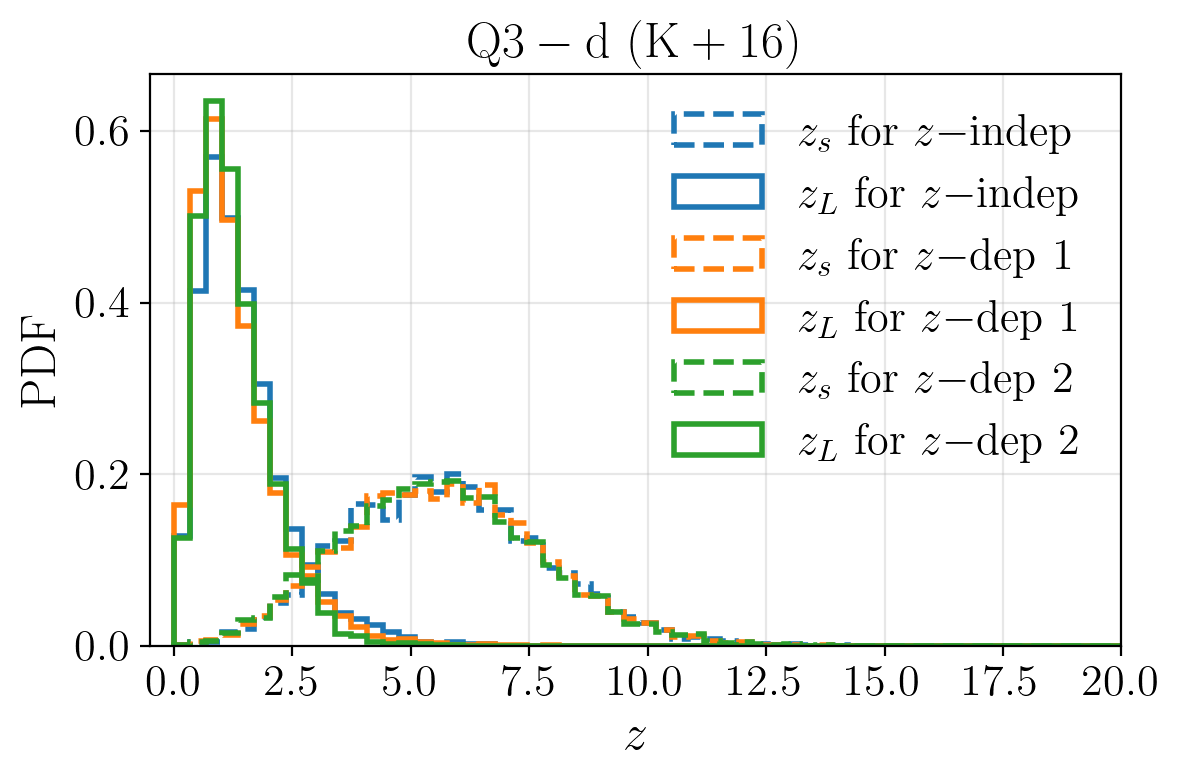

Percentage of events with z_l1 < 1: 36.6
Percentage of events with z_l1 < 3: 93.02
Percentage of events with z_l1 < 6: 99.82
Percentage of events with z_l2 < 1: 43.38
Percentage of events with z_l2 < 3: 94.72
Percentage of events with z_l2 < 6: 99.83999999999999
Percentage of events with z_l3 < 1: 41.56
Percentage of events with z_l3 < 3: 97.04
Percentage of events with z_l3 < 6: 100.0


In [13]:
# plots of redshift distributions of lenses and sources 

bins = np.linspace(0, 20, 60) 

file_paths= [ # edit according to the file paths if necessary
    ("github/HSnodSNhighaccr/HSnodSNhighaccr_z_indep.csv", "github/HSnodSNhighaccr/HSnodSNhighaccr_z_dep1.csv", "github/HSnodSNhighaccr/HSnodSNhighaccr_z_dep2.csv", 'HS-nod-SN-high-accr\ (B+20)', "HSnodSNhighaccr"),    
    ("github/HSnodnoSN/HSnodnoSN_z_indep.csv",             "github/HSnodnoSN/HSnodnoSN_z_dep1.csv",             "github/HSnodnoSN/HSnodnoSN_z_dep2.csv",             'HS-nod-noSN\ (B+20)',         "HSnodnoSN"),
    ("github/HSnodSN/HSnodSN_z_indep.csv",                 "github/HSnodSN/HSnodSN_z_dep1.csv",                 "github/HSnodSN/HSnodSN_z_dep2.csv",                 'HS-nod-SN\ (B+20)',           "HSnodSN"),
    ("github/PopIIId/PopIIId_z_indep.csv",                 "github/PopIIId/PopIIId_z_dep1.csv",                 "github/PopIIId/PopIIId_z_dep2.csv",                 'PopIII-d\ (K+16)',            "popIIId"),
    ("github/Q3nod/Q3nod_z_indep.csv",                     "github/Q3nod/Q3nod_z_dep1.csv",                     "github/Q3nod/Q3nod_z_dep2.csv",                     'Q3-nod\ (K+16)',              "Q3nod"),
    ("github/Q3d/Q3d_z_indep.csv",                         "github/Q3d/Q3d_z_dep1.csv",                         "github/Q3d/Q3d_z_dep2.csv",                         'Q3-d\ (K+16)',                "Q3d")
]

for file1, file2, file3, title, path in file_paths:
    df1 = pd.read_csv(file1)
    df2 = pd.read_csv(file2)
    df3 = pd.read_csv(file3)
    
    df1["z_merger_noisy"] = df1["z_merger"] + np.random.normal(0, 0.55, len(df1))
    df2["z_merger_noisy"] = df2["z_merger"] + np.random.normal(0, 0.55, len(df2))
    df3["z_merger_noisy"] = df3["z_merger"] + np.random.normal(0, 0.55, len(df3))
    
    plt.figure(figsize=(6, 4))
    plt.title(rf'$\mathrm{{{title}}}$', fontsize=18)
    
    plt.hist(df1["z_merger_noisy"], bins=bins, histtype='step', linewidth=2, ls = '--', color='tab:blue', label=r'$z_s \mathrm{\ for\ } z \mathrm{-indep}$', density= True)
    plt.hist(df1["z_l1"], bins=bins, histtype='step',           linewidth=2, ls = '-', color='tab:blue', label=r'$z_L \mathrm{\ for\ } z \mathrm{-indep}$', density= True)

    plt.hist(df2["z_merger_noisy"], bins=bins, histtype='step', linewidth=2, ls = '--', color='tab:orange', label=r'$z_s \mathrm{\ for\ } z \mathrm{-dep\ 1}$', density= True)
    plt.hist(df2["z_l2"],  bins=bins, histtype='step',          linewidth=2, ls = '-', color='tab:orange', label=r'$z_L \mathrm{\ for\ } z \mathrm{-dep\ 1}$', density= True)

    plt.hist(df3["z_merger_noisy"], bins=bins, histtype='step', linewidth=2, ls = '--', color='tab:green', label=r'$z_s \mathrm{\ for\ } z \mathrm{-dep\ 2}$', density= True)
    plt.hist(df3["z_l3"],  bins=bins, histtype='step',          linewidth=2, ls = '-', color='tab:green', label=r'$z_L \mathrm{\ for\ } z \mathrm{-dep\ 2}$', density= True)
    
    
    plt.xlabel(r'$z$', fontsize=18)
    plt.ylabel(r'$\mathrm{PDF}$', fontsize=18)
    plt.xticks(np.arange(0, 21, 2.5)) 
    plt.tick_params(labelsize=16)
    plt.grid(visible=None, which='major', axis='both', alpha=0.3)
    plt.legend(frameon=False, fontsize=16)
    plt.xlim(-0.5, 20)
    plt.savefig(f"github/Images/zlzs2_{path}.pdf", dpi=300, bbox_inches="tight")
    plt.tight_layout()
    plt.show()
    
    print("Percentage of events with z_l1 < 1:", (df1["z_l1"].lt(1).sum() / 5000) * 100)
    print("Percentage of events with z_l1 < 3:", (df1["z_l1"].lt(3).sum() / 5000) * 100)
    print("Percentage of events with z_l1 < 6:", (df1["z_l1"].lt(6).sum() / 5000) * 100)
    print("Percentage of events with z_l2 < 1:", (df2["z_l2"].lt(1).sum() / 5000) * 100)
    print("Percentage of events with z_l2 < 3:", (df2["z_l2"].lt(3).sum() / 5000) * 100)
    print("Percentage of events with z_l2 < 6:", (df2["z_l2"].lt(6).sum() / 5000) * 100)
    print("Percentage of events with z_l3 < 1:", (df3["z_l3"].lt(1).sum() / 5000) * 100)
    print("Percentage of events with z_l3 < 3:", (df3["z_l3"].lt(3).sum() / 5000) * 100)
    print("Percentage of events with z_l3 < 6:", (df3["z_l3"].lt(6).sum() / 5000) * 100)

# Strong Lensing Rates

Here 100 simulations are performed by randomly sampling the impact parameter $y$ for each catalog, then the results with the averages and dispersion of events that meet the defined conditions (2 detectable images, 1 detectable image and boosted) are saved in a .csv file.

In [14]:
file_paths= [ # edit according to the file paths if necessary
    ("github/HSnodSNhighaccr/HSnodSNhighaccr_z_indep.csv", 97.75171065493646),
    ("github/HSnodSNhighaccr/HSnodSNhighaccr_z_dep1.csv",  156.88735487919672),
    ("github/HSnodSNhighaccr/HSnodSNhighaccr_z_dep2.csv",  122.72950417280313),
    ("github/HSnodnoSN/HSnodnoSN_z_indep.csv",             21.618817018332756),
    ("github/HSnodnoSN/HSnodnoSN_z_dep1.csv",              35.02626970227671),
    ("github/HSnodnoSN/HSnodnoSN_z_dep2.csv",              27.654867256637168),
    ("github/HSnodSN/HSnodSN_z_indep.csv",                 23.194322029967065),
    ("github/HSnodSN/HSnodSN_z_dep1.csv",                  37.55445395823945),
    ("github/HSnodSN/HSnodSN_z_dep2.csv",                  29.633141705683638),
    ("github/PopIIId/PopIIId_z_indep.csv",                 725.689404934688),
    ("github/PopIIId/PopIIId_z_dep1.csv",                  1144.1647597254005),
    ("github/PopIIId/PopIIId_z_dep2.csv",                  878.7346221441124),
    ("github/Q3nod/Q3nod_z_indep.csv",                     1724.1379310344828),
    ("github/Q3nod/Q3nod_z_dep1.csv",                      2702.7027027027025),
    ("github/Q3nod/Q3nod_z_dep2.csv",                      2066.115702479339),
    ("github/Q3d/Q3d_z_indep.csv",                         26315.78947368421),
    ("github/Q3d/Q3d_z_dep1.csv",                          38461.53846153846),
    ("github/Q3d/Q3d_z_dep2.csv",                          27777.777777777777)
]  # the last number correspond to the number of 4-years realizations when considering 5,000 events and the number of intrinsic strongly lensed events     

results = []
n_runs = 100  

for file_path, norm in file_paths:   
    df = pd.read_csv(file_path)

    cond1_list, cond2_list, cond3_list = [], [], []

    for _ in range(n_runs):
        df["x"] = np.random.rand(len(df))
        df["y"] = df["x"]**0.5
        df["xp"] = df["y"] + 1
        df["xm"] = df["y"] - 1
        df["mup"] = 1 + (1 / df["y"]) 
        df["mum"] = 1 - (1 / df["y"]) 
        df["SNRp"] = df["Mean_SNR"] * np.sqrt(np.abs(df["mup"]))
        df["SNRm"] = df["Mean_SNR"] * np.sqrt(np.abs(df["mum"]))

        cond1 = (df['SNRm'] < 8) & (df['SNRp'] > 8)
        cond2 = (df['SNRm'] > 8) & (df['SNRp'] > 8) 
        cond3 = (df['Mean_SNR'] < 8) & (df['SNRp'] > 8)

        n_cond1 = df[cond1].shape[0] / norm
        n_cond2 = df[cond2].shape[0] / norm
        n_cond3 = df[cond3].shape[0] / norm

        cond1_list.append(n_cond1)
        cond2_list.append(n_cond2)
        cond3_list.append(n_cond3)

    res = {
        "File": file_path,
        "1Detected_mean": np.mean(cond1_list),
        "1Detected_std": np.std(cond1_list),
        "1Detected_min": np.min(cond1_list),
        "1Detected_max": np.max(cond1_list),
        "2Detected_mean": np.mean(cond2_list),
        "2Detected_std": np.std(cond2_list),
        "2Detected_min": np.min(cond2_list),
        "2Detected_max": np.max(cond2_list),
        "Boosted_mean": np.mean(cond3_list),
        "Boosted_std": np.std(cond3_list),
        "Boosted_min": np.min(cond3_list),
        "Boosted_max": np.max(cond3_list),
    }
    results.append(res)
    
    print(f"{file_path}")
    print(f"  1 Detected Mean: {res['1Detected_mean']:.3f}")
    print(f"  2 Detected Mean: {res['2Detected_mean']:.3f}")
    print(f"  Boosted Mean:    {res['Boosted_mean']:.3f}")
    
results_df = pd.DataFrame(results)
results_df.to_csv("github/SLrates_results_summary.csv", index=False)

github/HSnodSNhighaccr/HSnodSNhighaccr_z_indep.csv
  1 Detected Mean: 4.776
  2 Detected Mean: 46.098
  Boosted Mean:    0.420
github/HSnodSNhighaccr/HSnodSNhighaccr_z_dep1.csv
  1 Detected Mean: 2.973
  2 Detected Mean: 28.741
  Boosted Mean:    0.264
github/HSnodSNhighaccr/HSnodSNhighaccr_z_dep2.csv
  1 Detected Mean: 3.884
  2 Detected Mean: 36.603
  Boosted Mean:    0.375
github/HSnodnoSN/HSnodnoSN_z_indep.csv
  1 Detected Mean: 20.123
  2 Detected Mean: 210.154
  Boosted Mean:    2.281
github/HSnodnoSN/HSnodnoSN_z_dep1.csv
  1 Detected Mean: 12.717
  2 Detected Mean: 129.389
  Boosted Mean:    1.526
github/HSnodnoSN/HSnodnoSN_z_dep2.csv
  1 Detected Mean: 16.263
  2 Detected Mean: 163.744
  Boosted Mean:    1.918
github/HSnodSN/HSnodSN_z_indep.csv
  1 Detected Mean: 18.609
  2 Detected Mean: 195.445
  Boosted Mean:    1.933
github/HSnodSN/HSnodSN_z_dep1.csv
  1 Detected Mean: 11.542
  2 Detected Mean: 120.941
  Boosted Mean:    1.180
github/HSnodSN/HSnodSN_z_dep2.csv
  1 Detected 

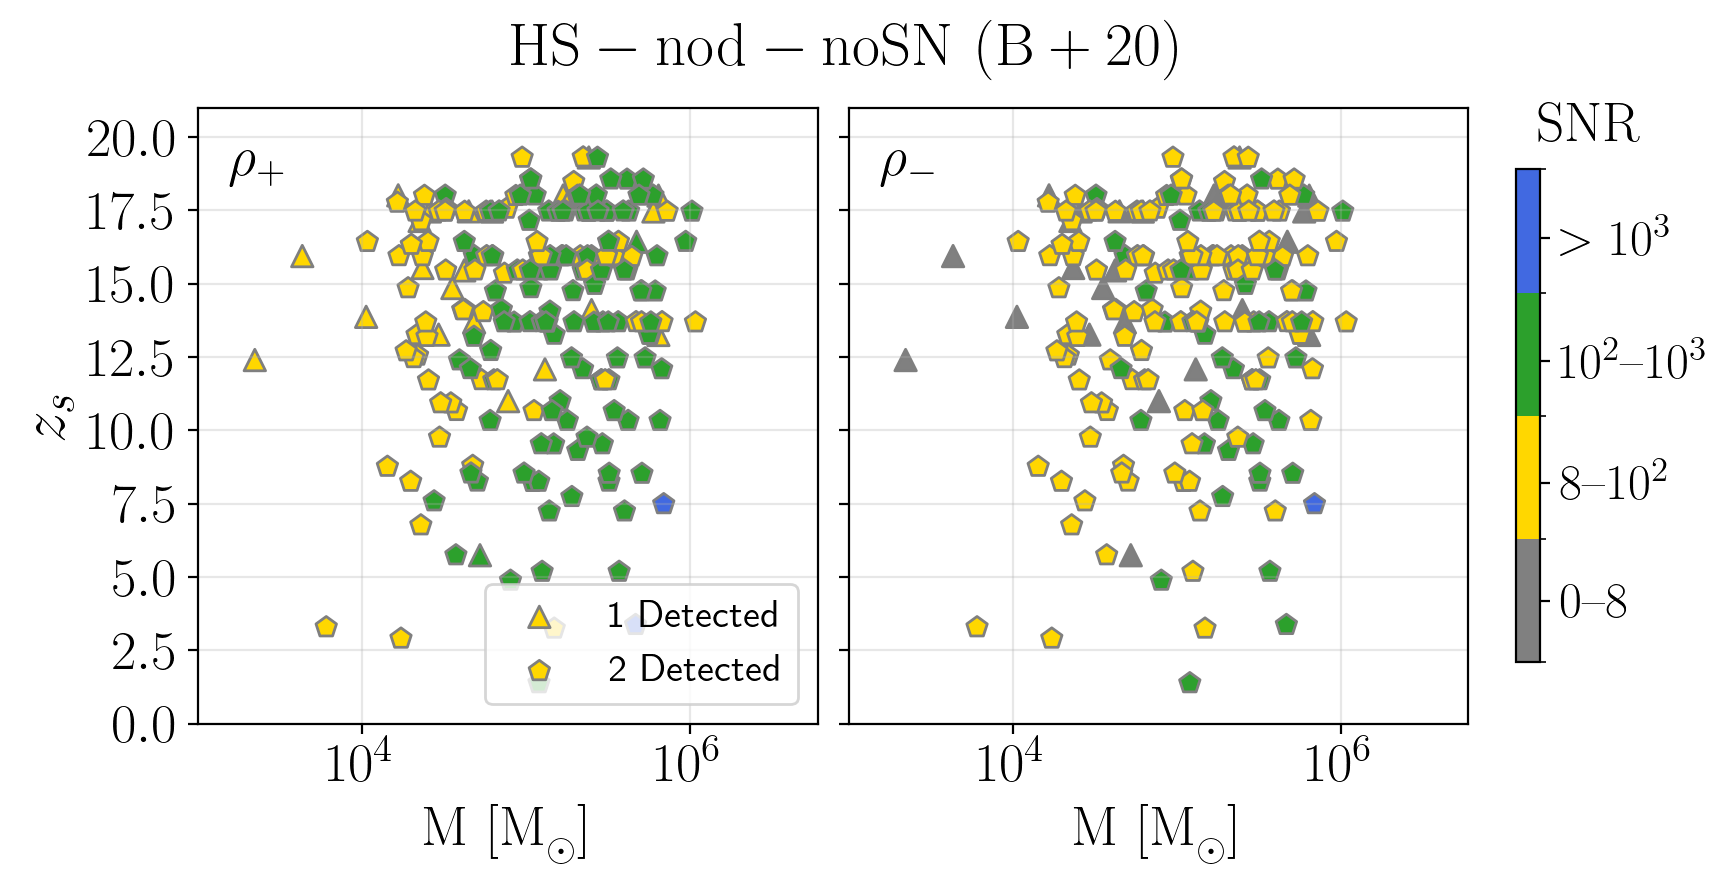

In [25]:
# lensed Events
from matplotlib.colors import BoundaryNorm, ListedColormap

df = pd.read_csv("github/HSnodnoSN/HSnodnoSN_z_indep.csv")

n = 213

df_sample = df.sample(n=int(n), random_state=101)

df_sample["x"] = np.random.rand(len(df_sample))
df_sample["y"] = df_sample["x"]**0.5
df_sample["xp"] = df_sample["y"] + 1
df_sample["xm"] = df_sample["y"] - 1
df_sample["mup"] = 1 + (1 / df_sample["y"]) 
df_sample["mum"] = 1 - (1 / df_sample["y"]) 
df_sample["SNRp"] = df_sample["Mean_SNR"] * np.sqrt(np.abs(df_sample["mup"]))
df_sample["SNRm"] = df_sample["Mean_SNR"] * np.sqrt(np.abs(df_sample["mum"]))

bounds = [0, 8, 100,1000,  10000]
colors = ['grey', 'gold','tab:green', 'royalblue']
cmap = ListedColormap(colors)
norm = BoundaryNorm(bounds, cmap.N)


cond1 = (df_sample['SNRm'] < 8) & (df_sample['SNRp'] > 8)
cond2 = (df_sample['SNRm'] > 8) & (df_sample['SNRp'] > 8)
cond3 = (df_sample['SNRp'] > 8) & (df_sample['SNRm'] < 8) & (df_sample['SNRm'] > 5)
cond4 = (df_sample['SNRp'] > 8) & (df_sample['SNRm'] < 5)

fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=False, sharey=True)

sc0a = axs[0].scatter(
    df_sample.loc[cond1, 'm1'] + df_sample.loc[cond1, 'm2'],
    df_sample.loc[cond1, 'z_merger'],
    c=df_sample.loc[cond1, 'SNRp'],
    cmap=cmap,
    norm=norm,
    alpha= 1,
    s=60,
    marker="^", 
    edgecolors = 'tab:grey',
    label="1 Detected"
)
sc0b = axs[0].scatter(
    df_sample.loc[cond2, 'm1'] + df_sample.loc[cond2, 'm2'],
    df_sample.loc[cond2, 'z_merger'],
    c=df_sample.loc[cond2, 'SNRp'],
    cmap=cmap,
    norm=norm,
    alpha= 1,
    s=60,
    marker="p", 
    edgecolors = 'tab:grey',
    label="2 Detected"
)
axs[0].set_xscale("log")
#axs[0].set_title(r"$\rho_+$", fontsize=20)
axs[0].set_xlabel(r"$\mathrm{M\ [M}_\odot]$", fontsize=20)
axs[0].set_ylabel(r"$z_s$", fontsize=23)
axs[0].grid(alpha=0.3)

axs[1].scatter(
    df_sample.loc[cond1, 'm1'] + df_sample.loc[cond1, 'm2'],
    df_sample.loc[cond1, 'z_merger'],
    c=df_sample.loc[cond1, 'SNRm'],
    cmap=cmap,
    norm=norm,
    alpha= 1,
    edgecolors = 'tab:grey',
    s=60,
    marker="^"
)
axs[1].scatter(
    df_sample.loc[cond2, 'm1'] + df_sample.loc[cond2, 'm2'],
    df_sample.loc[cond2, 'z_merger'],
    c=df_sample.loc[cond2, 'SNRm'],
    cmap=cmap,
    norm=norm,
    s=60,
    alpha= 1,
    edgecolors = 'tab:grey',
    marker="p"
)
axs[1].set_xscale("log")
#axs[1].set_title(r"$\rho_-$", fontsize=20)
axs[1].set_xlabel(r"$\mathrm{M\ [M}_\odot]$", fontsize=20)
axs[1].grid(alpha=0.3)


cbar = fig.colorbar(sc0a, ax=axs, orientation='vertical', pad=4, shrink=0.8)
cbar.ax.set_title(r"$\mathrm{SNR}$", fontsize=20, pad=10, x = 3)  # separo el título más arriba
cbar.set_ticks([4, 50, 500, 5000])  
cbar.set_ticklabels(['$0–8$', '$8–10^2$', '$10^2–10^3$', '$>10^3$'])
cbar.ax.tick_params(labelsize=18)

fig.suptitle(r"$\mathrm{HS-nod-noSN\ (B+20)}$", fontsize=22, y=0.99, x= 0.45)
plt.subplots_adjust(wspace=0.051, right=0.76)  # corro un poco los subplots a la izquierda

axs[0].text(0.05, 0.95, r"$\rho_{+}$", transform=axs[0].transAxes,
            fontsize=20, va="top", ha="left")

axs[1].text(0.05, 0.95, r"$\rho_{-}$", transform=axs[1].transAxes,
            fontsize=20, va="top", ha="left")


for ax in axs:
    ax.set_xlim(1e3, 6e6)
    ax.set_ylim(0, 21)
    ax.set_yticks(np.arange(0, 21, 2.5))
    ax.tick_params(labelsize=20)

axs[0].legend(fontsize=14, frameon=True, loc='lower right')

plt.savefig("github/Images/scatterlensedSNR_HSnodnoSN.pdf", dpi=300, bbox_inches="tight")
plt.show()

# Time Delays

Calculation and plots of time delays. First, functions are defined to sample the dispersion velocity $\sigma$ from their respective PDFs, and then the plots are constructed.


In [15]:
h = cosmo.h
H0 = cosmo.H0.value
ckm = 3.0e5        
cmpc = 9.72e-15    

phi_star0 = 2.099e-2 * (h/0.7)**3   # Mpc^-3
sigma_star0 = 113.78                 # km/s
alpha, beta = 0.94, 1.85
nu_n, nu_v = -1.18, 0.18

# -- z-independent --
def phi_indep(sigma):    
    return (phi_star0 * (sigma/sigma_star0)**alpha * np.exp(-(sigma/sigma_star0)**beta) * beta/(gamma(alpha/beta)*sigma))

# -- z-dependent1 --
def phi_dep1(sigma, z): 
    return ((phi_star0*(1+z)**nu_n) * (sigma/(sigma_star0*(1+z)**nu_v))**alpha * np.exp(-(sigma/(sigma_star0*(1+z)**nu_v))**beta) * beta/(gamma(alpha/beta)*sigma))

# -- z-dependent2 --
def phi_dep2(sigma, z):
    a0, a1, a2   = 7.391498, 5.729400, -1.120552
    al0, al1, al2 = -6.863393, -5.273271, 1.104114
    be0, be1, be2 = 2.852083, 1.255696, -0.286638
    ga0, ga1, ga2 = 0.067032, -0.048683, 0.007648

    def phi_hyd(sigma, z):
        A_hyd     = a0  + a1*z  + a2*z**2
        alpha_hyd = al0 + al1*z + al2*z**2
        beta_hyd  = be0 + be1*z + be2*z**2
        gamma_hyd = ga0 + ga1*z + ga2*z**2
        sigma_star_hyd = 10**gamma_hyd

        x = np.log10(sigma / sigma_star_hyd)
        n = 10**(A_hyd + alpha_hyd*x + beta_hyd*x**2 - np.exp(x))
        phi1 = n/sigma * (alpha_hyd + 2*beta_hyd*x - np.exp(x))
        return phi1

    phi_z = phi_hyd(sigma, z)
    phi_0 = phi_hyd(sigma, 0.0)
    ratio = phi_z / phi_0

    return ratio * phi_indep(sigma)

def sample_sigma_from_phi(func, z=None, sigma_min=63, sigma_max=1000, npts=50000, N=1):
    sigma = np.linspace(sigma_min, sigma_max, npts)
    vals = func(sigma) if z is None else func(sigma, z)
    vals = np.clip(vals, 0, None)  
    vals = np.nan_to_num(vals, nan=0.0, neginf=0.0, posinf=0.0)
    vals *= sigma**4
    pdf = vals / simpson(vals, x=sigma)
    cdf = np.cumsum(pdf)
    cdf /= cdf[-1]
    return np.interp(np.random.rand(N), cdf, sigma)

In [19]:

paths= [("github/PopIIId/PopIIId_z_indep.csv",                 "github/PopIIId/PopIIId_z_dep1.csv",                 "github/PopIIId/PopIIId_z_dep2.csv",                 'PopIII-d\ (K+16)',            "popIIId"),
        ("github/Q3d/Q3d_z_indep.csv",                         "github/Q3d/Q3d_z_dep1.csv",                         "github/Q3d/Q3d_z_dep2.csv",                         'Q3-d\ (K+16)',                "Q3d"),
        ("github/Q3nod/Q3nod_z_indep.csv",                     "github/Q3nod/Q3nod_z_dep1.csv",                     "github/Q3nod/Q3nod_z_dep2.csv",                     'Q3-nod\ (K+16)',              "Q3nod"),
        ("github/HSnodnoSN/HSnodnoSN_z_indep.csv",             "github/HSnodnoSN/HSnodnoSN_z_dep1.csv",             "github/HSnodnoSN/HSnodnoSN_z_dep2.csv",             'HS-nod-noSN\ (B+20)',         "HSnodnoSN"),
        ("github/HSnodSN/HSnodSN_z_indep.csv",                 "github/HSnodSN/HSnodSN_z_dep1.csv",                 "github/HSnodSN/HSnodSN_z_dep2.csv",                 'HS-nod-SN\ (B+20)',           "HSnodSN"),
        ("github/HSnodSNhighaccr/HSnodSNhighaccr_z_indep.csv", "github/HSnodSNhighaccr/HSnodSNhighaccr_z_dep1.csv", "github/HSnodSNhighaccr/HSnodSNhighaccr_z_dep2.csv", 'HS-nod-SN-high-accr\ (B+20)', "HSnodSNhighaccr")    
]

for z_indep, z_dep1, z_dep2, title, file in paths:
    df1 = pd.read_csv(z_indep)
    df2 = pd.read_csv(z_dep1)
    df3 = pd.read_csv(z_dep2)


    # --- z indep ---
    df1["y1"] = np.random.rand(len(df1))**0.5
    df1["sigma_z_indep"] = df1["z_l1"].apply(lambda z: sample_sigma_from_phi(phi_indep, N=1)[0])
    df1["deltat_z_indep"] = ((32*np.pi**2)/cmpc) * (df1["sigma_z_indep"]/ckm)**4 * (df1["Da_l1"]*df1["Da_l1s"]/df1["Da_s"]) * (1+df1["z_l1"])
    df1["timedelay_z_indep"] = df1["y1"] * df1["deltat_z_indep"]

    # --- z dep1 ---
    df2["y2"] = np.random.rand(len(df2))**0.5
    df2["sigma_z_dep1"] = df2["z_l2"].apply(lambda z: sample_sigma_from_phi(phi_dep1, z=z, N=1)[0])
    df2["deltat_z_dep1"] = ((32*np.pi**2)/cmpc) * (df2["sigma_z_dep1"]/ckm)**4 * (df2["Da_l2"]*df2["Da_l2s"]/df2["Da_s"]) * (1+df2["z_l2"])
    df2["timedelay_z_dep1"] = df2["y2"] * df2["deltat_z_dep1"]

    # --- z dep2 ---
    df3["y3"] = np.random.rand(len(df3))**0.5
    df3["sigma_z_dep2"] = df3["z_l3"].apply(lambda z: sample_sigma_from_phi(phi_dep2, z=z, N=1)[0])
    df3["deltat_z_dep2"] = ((32*np.pi**2)/cmpc) * (df3["sigma_z_dep2"]/ckm)**4 * (df3["Da_l3"]*df3["Da_l3s"]/df3["Da_s"]) * (1+df3["z_l3"])
    df3["timedelay_z_dep2"] = df3["y3"] * df3["deltat_z_dep2"]

    
    df1.to_csv(z_indep.replace(".csv", "_timedelays.csv"), index=False)
    df2.to_csv(z_dep1.replace(".csv", "_timedelays.csv"), index=False)
    df3.to_csv(z_dep2.replace(".csv", "_timedelays.csv"), index=False)

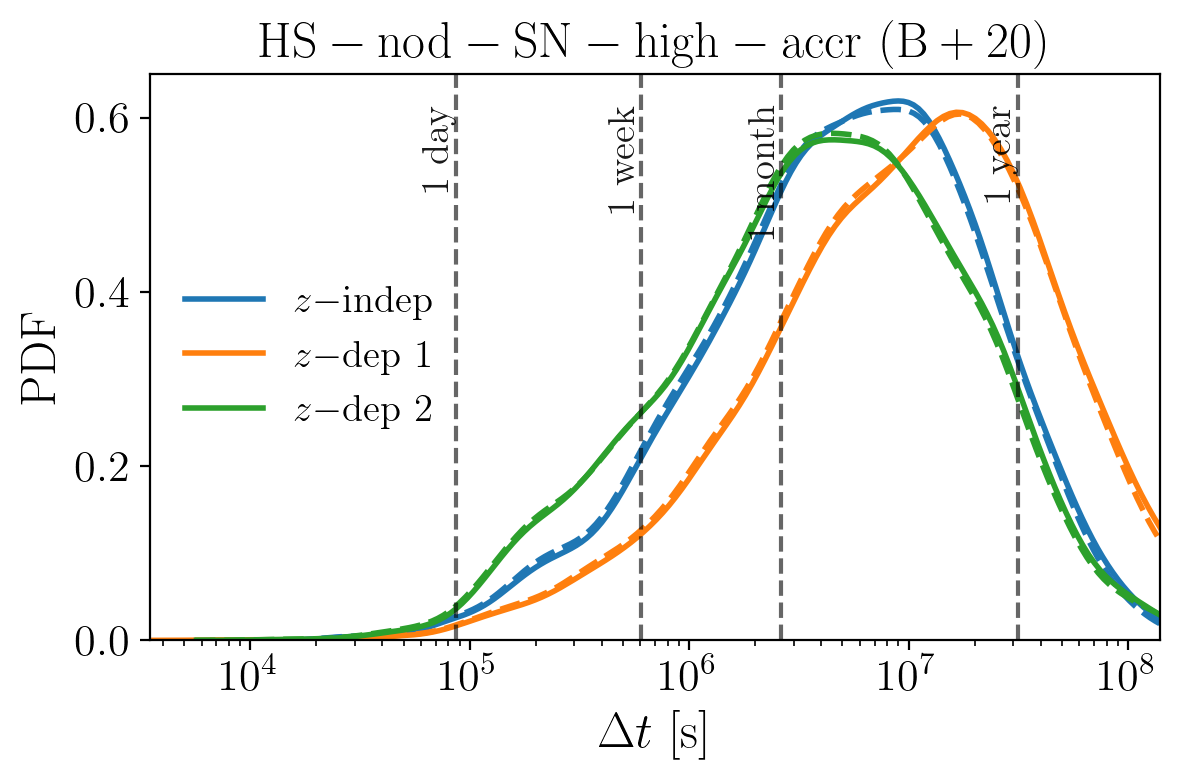

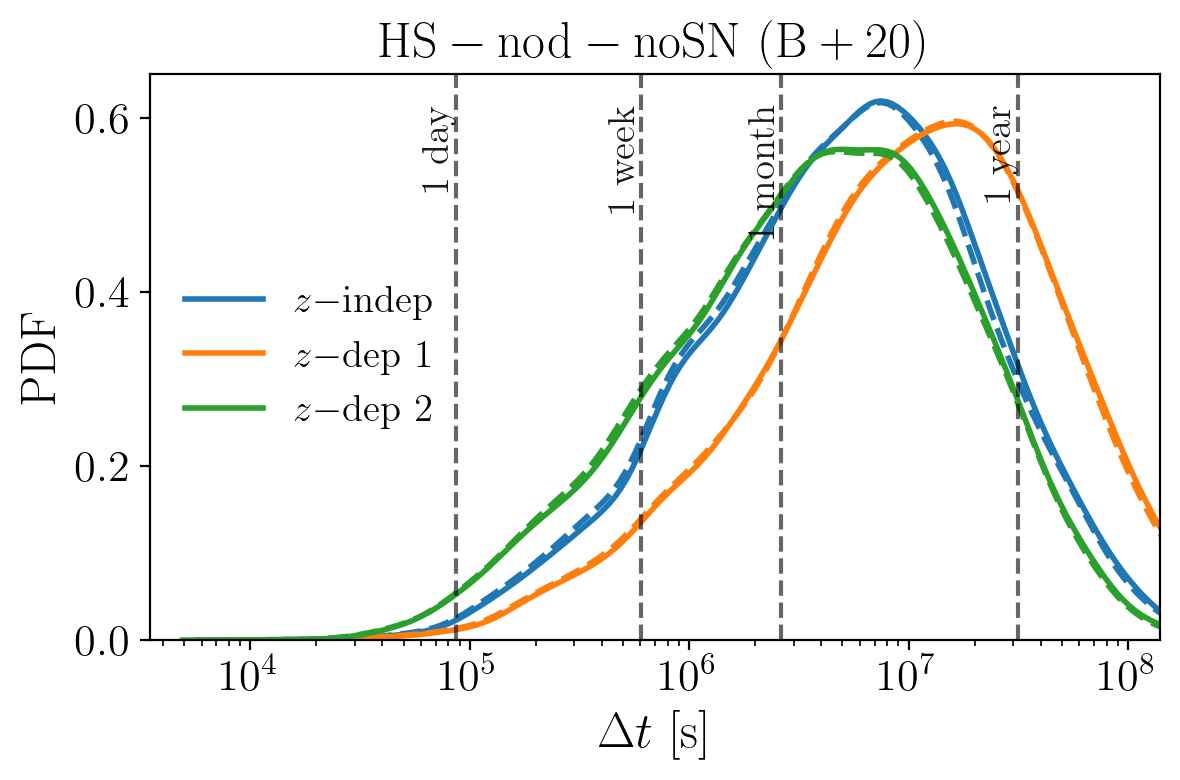

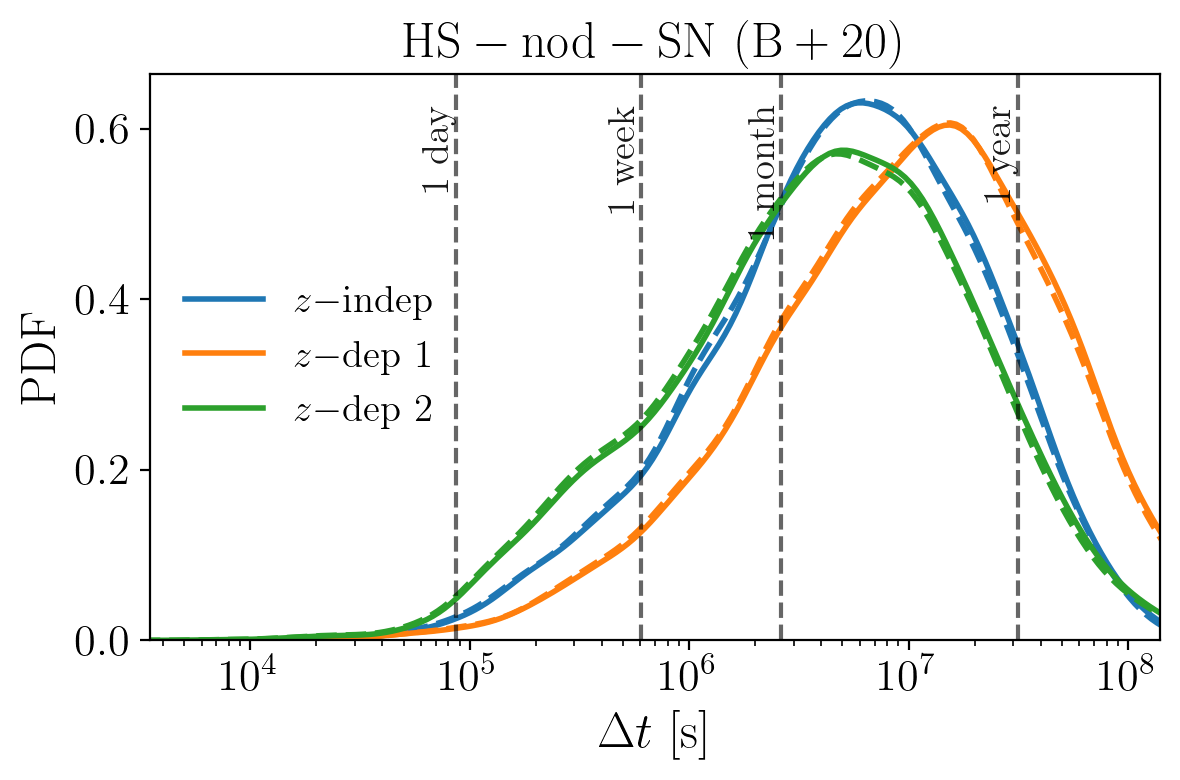

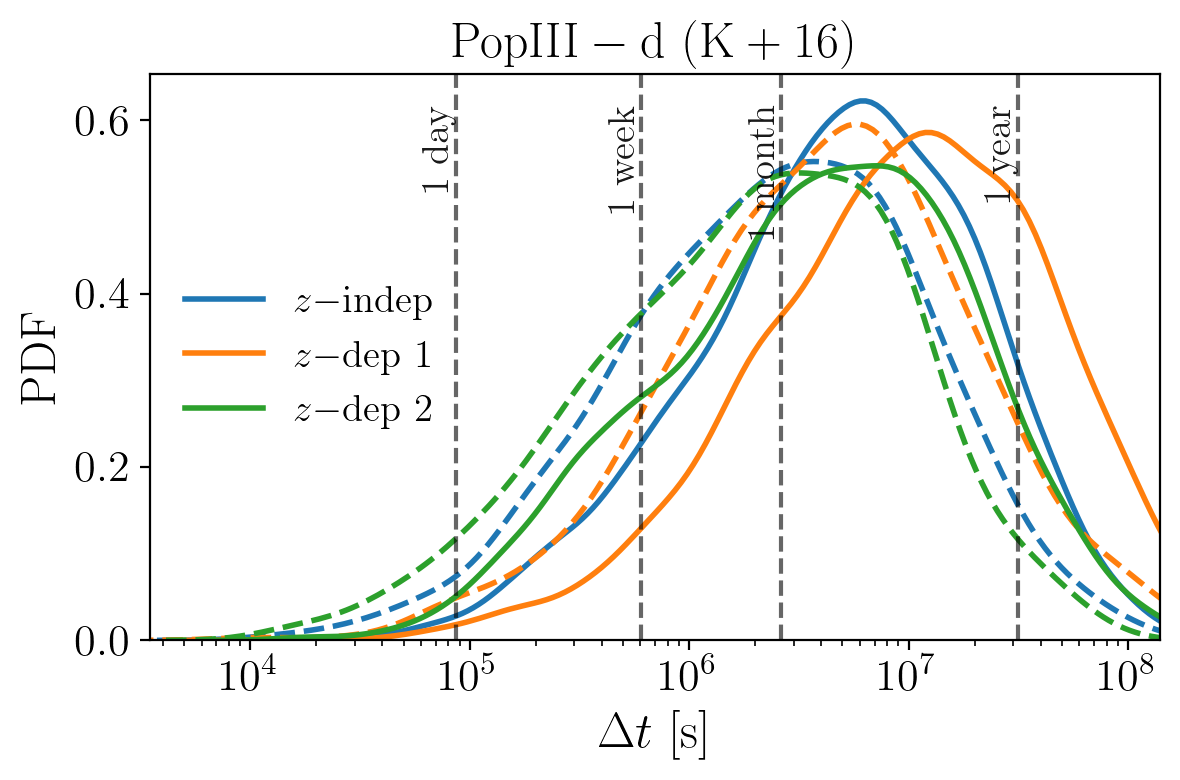

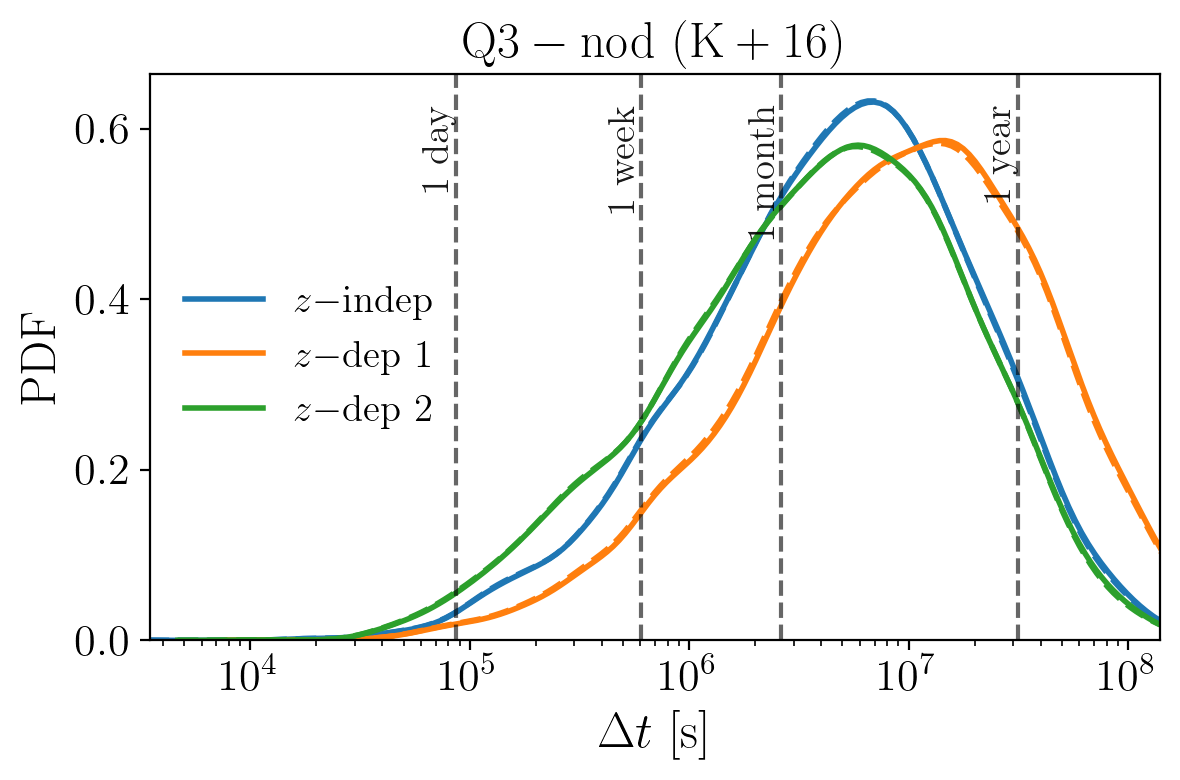

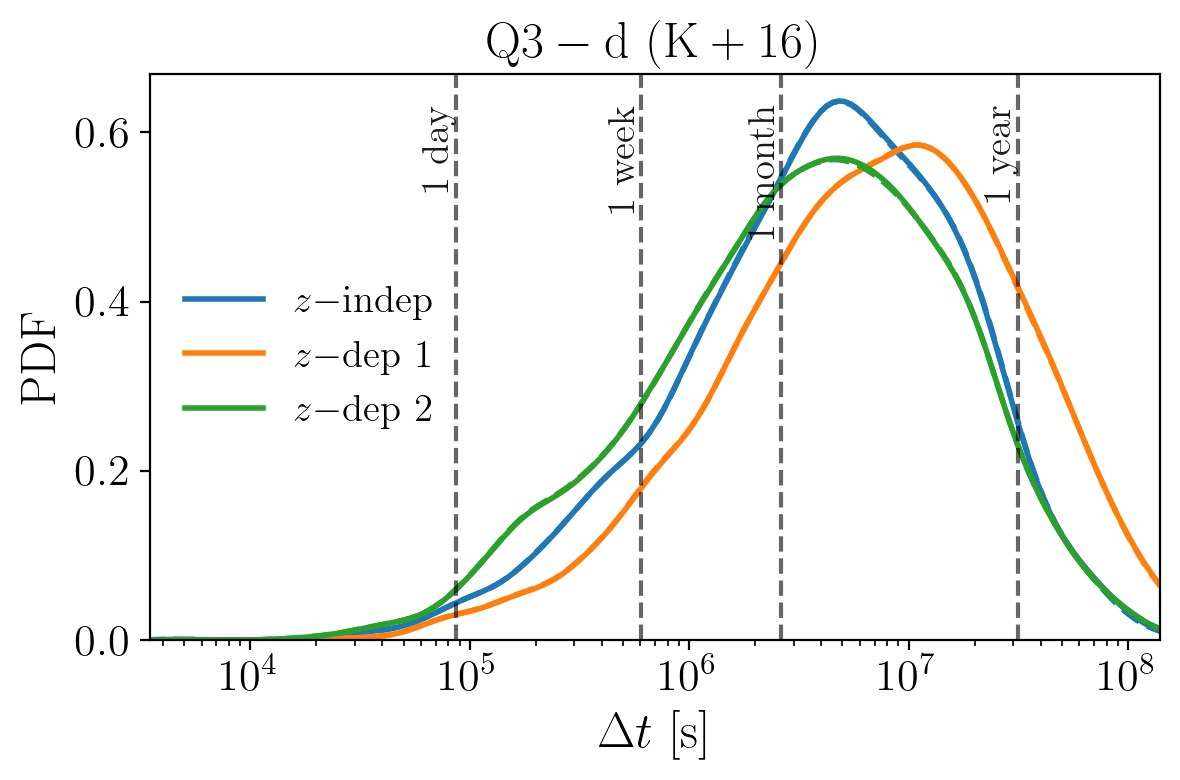

In [21]:
import seaborn as sns
from scipy.stats import gaussian_kde

sec_day = 86400
sec_week = 7 * sec_day
sec_month = 30.44 * sec_day
sec_year = 365.25 * sec_day

paths= [# edit according to the file paths if necessary
        ("github/HSnodSNhighaccr/HSnodSNhighaccr_z_indep_timedelays.csv", "github/HSnodSNhighaccr/HSnodSNhighaccr_z_dep1_timedelays.csv", "github/HSnodSNhighaccr/HSnodSNhighaccr_z_dep2_timedelays.csv", 'HS-nod-SN-high-accr\ (B+20)', "HSnodSNhighaccr"),    
        ("github/HSnodnoSN/HSnodnoSN_z_indep_timedelays.csv",             "github/HSnodnoSN/HSnodnoSN_z_dep1_timedelays.csv",             "github/HSnodnoSN/HSnodnoSN_z_dep2_timedelays.csv",             'HS-nod-noSN\ (B+20)',         "HSnodnoSN"),
        ("github/HSnodSN/HSnodSN_z_indep_timedelays.csv",                 "github/HSnodSN/HSnodSN_z_dep1_timedelays.csv",                 "github/HSnodSN/HSnodSN_z_dep2_timedelays.csv",                 'HS-nod-SN\ (B+20)',           "HSnodSN"),
        ("github/PopIIId/PopIIId_z_indep_timedelays.csv",                 "github/PopIIId/PopIIId_z_dep1_timedelays.csv",                 "github/PopIIId/PopIIId_z_dep2_timedelays.csv",                 'PopIII-d\ (K+16)',            "PopIIId"),
        ("github/Q3nod/Q3nod_z_indep_timedelays.csv",                     "github/Q3nod/Q3nod_z_dep1_timedelays.csv",                     "github/Q3nod/Q3nod_z_dep2_timedelays.csv",                     'Q3-nod\ (K+16)',              "Q3nod"),
        ("github/Q3d/Q3d_z_indep_timedelays.csv",                         "github/Q3d/Q3d_z_dep1_timedelays.csv",                         "github/Q3d/Q3d_z_dep2_timedelays.csv",                         'Q3-d\ (K+16)',                "Q3d")
]

for z_indep, z_dep1, z_dep2, title, file in paths:
    df1 = pd.read_csv(z_indep)
    df2 = pd.read_csv(z_dep1)
    df3 = pd.read_csv(z_dep2)
    
    timedelay_z_indep = df1["timedelay_z_indep"].values
    timedelay_z_dep1  = df2["timedelay_z_dep1"].values
    timedelay_z_dep2  = df3["timedelay_z_dep2"].values

    df1["xp"] = df1["y1"] + 1
    df1["xm"] = df1["y1"] - 1
    df1["mup"] = 1 + (1 / df1["y1"]) 
    df1["mum"] = 1 - (1 / df1["y1"]) 
    df1["SNRp"] = df1["Mean_SNR"] * np.sqrt(np.abs(df1["mup"]))
    df1["SNRm"] = df1["Mean_SNR"] * np.sqrt(np.abs(df1["mum"]))
    
    df2["xp"] = df2["y2"] + 1
    df2["xm"] = df2["y2"] - 1
    df2["mup"] = 1 + (1 / df2["y2"]) 
    df2["mum"] = 1 - (1 / df2["y2"]) 
    df2["SNRp"] = df2["Mean_SNR"] * np.sqrt(np.abs(df2["mup"]))
    df2["SNRm"] = df2["Mean_SNR"] * np.sqrt(np.abs(df2["mum"]))
    
    df3["xp"] = df3["y3"] + 1
    df3["xm"] = df3["y3"] - 1
    df3["mup"] = 1 + (1 / df3["y3"]) 
    df3["mum"] = 1 - (1 / df3["y3"]) 
    df3["SNRp"] = df3["Mean_SNR"] * np.sqrt(np.abs(df3["mup"]))
    df3["SNRm"] = df3["Mean_SNR"] * np.sqrt(np.abs(df3["mum"]))

    mask1 = (df1["SNRp"] > 8) & (df1["SNRm"] > 8)
    mask2 = (df2["SNRp"] > 8) & (df2["SNRm"] > 8)
    mask3 = (df3["SNRp"] > 8) & (df3["SNRm"] > 8)

    timedelay_z_indep_detec = df1.loc[mask1, "timedelay_z_indep"].values
    timedelay_z_dep1_detec = df2.loc[mask2, "timedelay_z_dep1"].values
    timedelay_z_dep2_detec  = df3.loc[mask3, "timedelay_z_dep2"].values
    
    plt.figure(figsize=(6, 4))
    plt.xscale("log")

    sns.kdeplot(
        timedelay_z_indep,
        label=r"$z\mathrm{-indep}$",
        color="tab:blue",
        linewidth=2
    )
    sns.kdeplot(
        timedelay_z_indep_detec,
        color="tab:blue",
        linewidth=2,
        linestyle='--'
    )
    
    sns.kdeplot(
        timedelay_z_dep1,
        label=r"$z\mathrm{-dep\ 1}$",
        color="tab:orange",
        linewidth=2
    )
    sns.kdeplot(
        timedelay_z_dep1_detec,
        color="tab:orange",
        linewidth=2,
        linestyle='--'
    )
    sns.kdeplot(
        timedelay_z_dep2,
        label=r"$z\mathrm{-dep\ 2}$",
        color="tab:green",
        linewidth=2
    )
    sns.kdeplot(
        timedelay_z_dep2_detec,
        color="tab:green",
        linestyle='--',
        linewidth=2
    )


    for val, ref_label in zip([sec_day, sec_week, sec_month, sec_year], [r"$\mathrm{1\ day}$", r"$\mathrm{1\ week}$", r"$\mathrm{1\ month}$", r"$\mathrm{1\ year}$"]):
        plt.axvline(val, color="k", linestyle="--", alpha=0.6)
        plt.text(val, plt.ylim()[1]*0.95, ref_label, color="k", rotation=90, ha='right', va='top', fontsize=14, alpha=0.9)

    plt.xlabel(r"$\Delta t \ \mathrm{[s]}$", fontsize=18)
    plt.ylabel(r"$\mathrm{PDF}$", fontsize=18)
    plt.xlim(3.5e3, 1.4e8)
    plt.legend(frameon=False, fontsize=14, loc = 'center left')
    plt.title(rf'$\mathrm{{{title}}}$', fontsize=18)
    plt.tick_params(labelsize=16)
    plt.tight_layout()

    plt.savefig(f"github/Images/timedelays_{file}_detected.pdf", dpi=300)
    plt.show()

# Velocity Dispersion Functions

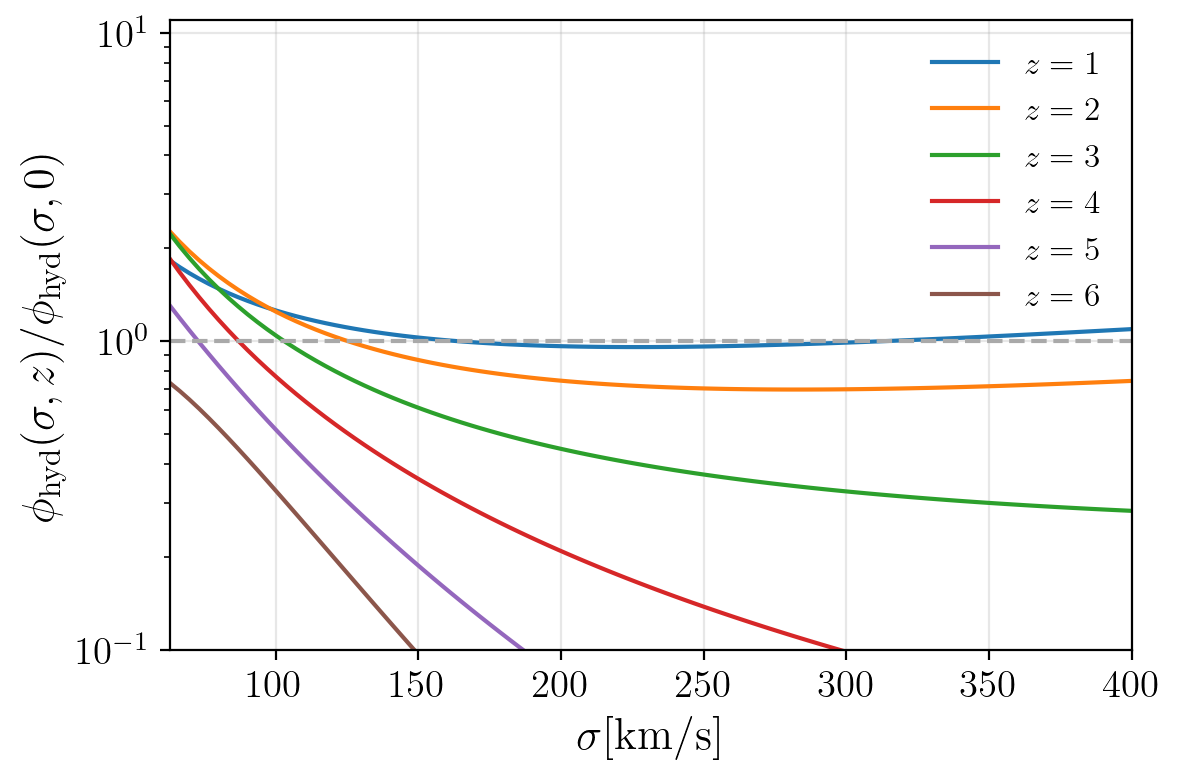

In [22]:
z_vals = np.array([ 0,1, 2, 3, 4, 5, 6])
sigma = np.linspace(63, 400, 100)

a0, a1, a2     = 7.391498     ,  5.729400     , -1.120552
al0, al1, al2  = -6.86339338  , -5.27327109   , 1.10411386
be0, be1, be2  = 2.85208259   , 1.25569600    , -0.28663846
ga0, ga1, ga2  = 0.06703215   , -0.04868317   , 0.00764841

def phi_hyd(z, sigma):
    A_hyd          = a0  + a1*z  + a2*z**2
    alpha_hyd      = al0 + al1*z + al2*z**2
    beta_hyd       = be0 + be1*z + be2*z**2
    gamma_hyd      = ga0 + ga1*z + ga2*z**2
    sigma_star_hyd = 10**gamma_hyd

    x = np.log10(sigma / sigma_star_hyd)
    
    n = 10**(A_hyd + alpha_hyd*x + beta_hyd*x**2 - np.exp(x))
    phi1 = n/sigma * (alpha_hyd + 2*beta_hyd*x - np.exp(x))
    return phi1

phi_hyd = {z: phi_hyd(z, sigma) for z in z_vals}

phi_hyd0 = phi_hyd[0]
N = {z: phi_hyd[z] / phi_hyd0 for z in z_vals}


plt.figure(figsize=(6,4))

for z in [1,2,3,4,5,6]:
    plt.plot(sigma, N[z], label=f"$z={z}$", linewidth=1.5 )
plt.axhline(1.0, ls="--", c="darkgrey", lw=1.5)
plt.xlabel(r"$\sigma \mathrm{ [km/s]}$", fontsize= 16)
plt.ylabel(r"$\phi_{\rm hyd}(\sigma, z)/\phi_{\rm hyd}(\sigma, 0)$", fontsize= 16)
plt.legend(fontsize= 12, frameon=False, loc='upper right')
plt.xlim(63, 400)
plt.ylim(0.1, 11)
plt.yscale('log')
plt.grid(True ,alpha=0.3)
plt.tick_params(labelsize = 14)
plt.tight_layout()

plt.savefig("github/Images/VDF_hydro_python.pdf", dpi=300)
plt.show()

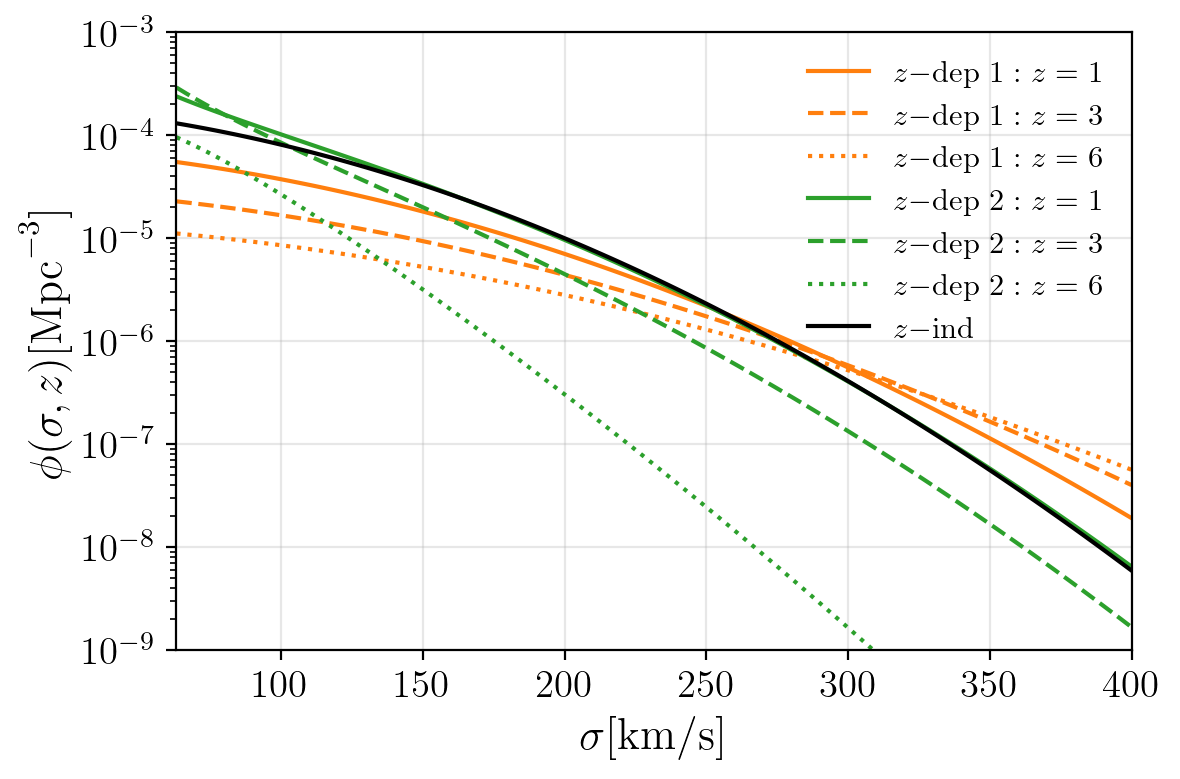

In [23]:
z_vals = np.array([1,3,6])
lines= ('-','--',':')

h = cosmo.h
H0 = cosmo.H0.value 
sigma = np.linspace(63, 400, 100)

phi_star0 = 2.099e-2 * (h/0.7)**3   
sigma_star0 = 113.78                
alpha, beta = 0.94, 1.85
nu_n, nu_v = -1.18,0.18               
c_km_s = 3.0e5                     

# -- z-independent --
def phi_indep(sigma):    
    phi_indep = phi_star0*(sigma/sigma_star0)**alpha*np.exp(-(sigma/sigma_star0)**beta)*beta/(gamma(alpha/beta)*sigma)
    return phi_indep

# -- z-dependent1 --
def phi_dep1(sigma, z): 
    phi_dep1 = (phi_star0*(1+z)**nu_n)*(sigma/(sigma_star0*(1+z)**nu_v))**alpha*np.exp(-(sigma/(sigma_star0*(1+z)**nu_v))**beta)*beta/(gamma(alpha/beta)*sigma)
    return phi_dep1
    
# -- z-dependent2 --
def phi_dep2(sigma, z):
    a0, a1, a2   = 7.391498, 5.729400, -1.120552
    al0, al1, al2 = -6.863393, -5.273271, 1.104114
    be0, be1, be2 = 2.852083, 1.255696, -0.286638
    ga0, ga1, ga2 = 0.067032, -0.048683, 0.007648

    def phi_hyd(sigma, z):
        A_hyd     = a0  + a1*z  + a2*z**2
        alpha_hyd = al0 + al1*z + al2*z**2
        beta_hyd  = be0 + be1*z + be2*z**2
        gamma_hyd = ga0 + ga1*z + ga2*z**2
        sigma_star_hyd = 10**gamma_hyd

        x = np.log10(sigma / sigma_star_hyd)
        n = 10**(A_hyd + alpha_hyd*x + beta_hyd*x**2 - np.exp(x))

        phi1 = n/sigma * (alpha_hyd + 2*beta_hyd*x - np.exp(x))
        return phi1

    phi_z = phi_hyd(sigma, z)
    phi_0 = phi_hyd(sigma, 0.0)
    ratio = phi_z / phi_0

    return ratio * phi_indep(sigma)

plt.figure(figsize=(6,4))


for i,j in zip(z_vals, lines):
    plt.plot(sigma, phi_dep1(sigma, i), label = fr"$z\mathrm{{-dep\ 1:}}\ z={i}$", c = 'tab:orange', linestyle=j, lw = 1.5)
    
for i,j in zip(z_vals, lines):
    plt.plot(sigma, phi_dep2(sigma, i), label = fr"$z\mathrm{{-dep\ 2:}}\ z={i}$", c = 'tab:green', linestyle=j, lw = 1.5)


plt.plot(sigma, phi_indep(sigma), label= r'$z\mathrm{-ind}$', c= 'k', lw = 1.5)    


plt.xlabel(r"$\sigma \mathrm{ [km/s]}$", fontsize= 16)
plt.ylabel(r"$\phi(\sigma, z)\mathrm{ [Mpc}^{-3}]$", fontsize= 16)
plt.xlim(63, 400)
plt.ylim(1e-9,1e-3)
plt.yscale('log')
plt.grid(True ,alpha=0.3)
plt.legend(fontsize= 11, frameon=False, loc='upper right')
plt.tick_params(labelsize = 14)
plt.tight_layout()
plt.savefig("github/Images/VDF_comparison_python.pdf", dpi=300)
plt.show()